# Import

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.0+cu113
     |████████████████████████████████| 7.9 MB 33.8 MB/s 
     |████████████████████████████████| 3.5 MB 40.0 MB/s 


In [ ]:
import numpy as np
import warnings
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
from collections import Counter
from collections.abc import Iterable
import argparse
import os
import sys
import time
import pickle
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch_geometric
from sklearn.metrics import r2_score

from torch.nn import Linear

from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import DataLoader as PYG_DataLoader
from torch_geometric.data import Data
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score, roc_auc_score, recall_score, precision_score
from scipy import interp

drive.mount('/content/drive')

Mounted at /content/drive


# Raw Data

In [ ]:
edge_path = "/content/drive/MyDrive/miRNA/graph/edge.pkl"
edge_attr_path = "/content/drive/MyDrive/miRNA/graph/edge_attr.pkl"
node_path = "/content/drive/MyDrive/miRNA/graph/node.pkl"
mesh_emb_path = '/content/drive/MyDrive/miRNA/embedding/mesh_embs.npy'
mesh_vocab_path = '/content/drive/MyDrive/miRNA/embedding/mesh_vocab.npy'

In [ ]:
# circulation
all_x_disease_path = '/content/drive/MyDrive/miRNA/last_data/cir_X_Disease_v3.npy'
all_x_rna_path = '/content/drive/MyDrive/miRNA/last_data/cir_X_RNA_v3.npy'
all_pre_x_rna_path = '/content/drive/MyDrive/miRNA/last_data/cir_pre_RNA_x_v3.npy'
all_y_soft_path = '/content/drive/MyDrive/miRNA/last_data/cir_soft_y_v3.npy'
all_y_hard_path = '/content/drive/MyDrive/miRNA/last_data/cir_hard_y_v3.npy'
cir_hair_x_path = '/content/drive/MyDrive/miRNA/last_data/cir_pre_hair_X_v3.npy'
snd_x_path = "/content/drive/MyDrive/miRNA/last_data/cir_snd_X_v3.npy"

In [ ]:
# all
all_x_disease_path = '/content/drive/MyDrive/miRNA/last_data/all_X_Disease_v3.npy'
all_x_rna_path = '/content/drive/MyDrive/miRNA/last_data/all_X_RNA_v3.npy'
all_pre_x_rna_path = '/content/drive/MyDrive/miRNA/last_data/all_pre_RNA_x_v3.npy'
all_y_soft_path = '/content/drive/MyDrive/miRNA/last_data/all_soft_y_v3.npy'
all_y_hard_path = '/content/drive/MyDrive/miRNA/last_data/all_hard_y_v3.npy'
all_hair_x_path = '/content/drive/MyDrive/miRNA/last_data/all_pre_hair_X_v3.npy'
snd_x_path = "/content/drive/MyDrive/miRNA/last_data/all_snd_X_v3.npy"

In [ ]:
# tissue
all_x_disease_path = '/content/drive/MyDrive/miRNA/last_data/tis_X_Disease_v3.npy'
all_x_rna_path = '/content/drive/MyDrive/miRNA/last_data/tis_X_RNA_v3.npy'
all_pre_x_rna_path = '/content/drive/MyDrive/miRNA/last_data/tis_pre_RNA_x_v3.npy'
all_y_soft_path = '/content/drive/MyDrive/miRNA/last_data/tis_soft_y_v3.npy'
all_y_hard_path = '/content/drive/MyDrive/miRNA/last_data/tis_hard_y_v3.npy'
tis_hair_x_path = '/content/drive/MyDrive/miRNA/last_data/tis_pre_hair_X_v3.npy'
snd_x_path = "/content/drive/MyDrive/miRNA/last_data/tis_snd_X_v3.npy"

In [ ]:
# gen
all_x_disease_path = '/content/drive/MyDrive/miRNA/last_data/gen_X_Disease_v3.npy'
all_x_rna_path = '/content/drive/MyDrive/miRNA/last_data/gen_X_RNA_v3.npy'
all_pre_x_rna_path = '/content/drive/MyDrive/miRNA/last_data/gen_pre_RNA_x_v3.npy'
all_y_soft_path = '/content/drive/MyDrive/miRNA/last_data/gen_soft_y_v3.npy'
all_y_hard_path = '/content/drive/MyDrive/miRNA/last_data/gen_hard_y_v3.npy'
gen_hair_x_path = '/content/drive/MyDrive/miRNA/last_data/gen_pre_hair_X_v3.npy'
snd_x_path = "/content/drive/MyDrive/miRNA/last_data/gen_snd_X_v3.npy"

In [ ]:
# cir
all_orig_x_disease = np.load(all_x_disease_path, allow_pickle=True)
all_orig_x_rna = np.load(all_x_rna_path, allow_pickle=True)
all_orig_pre_x_rna = np.load(all_pre_x_rna_path, allow_pickle=True)

all_hair_x = np.load(cir_hair_x_path, allow_pickle=True)
snd_x = np.load(snd_x_path, allow_pickle=True)

all_orig_Y_soft = np.load(all_y_soft_path, allow_pickle=True)
all_orig_Y_hard = np.load(all_y_hard_path, allow_pickle=True)

In [ ]:
# all
all_orig_x_disease = np.load(all_x_disease_path, allow_pickle=True)
all_orig_x_rna = np.load(all_x_rna_path, allow_pickle=True)
all_orig_pre_x_rna = np.load(all_pre_x_rna_path, allow_pickle=True)

all_hair_x = np.load(all_hair_x_path, allow_pickle=True)
snd_x = np.load(snd_x_path, allow_pickle=True)

all_orig_Y_soft = np.load(all_y_soft_path, allow_pickle=True)
all_orig_Y_hard = np.load(all_y_hard_path, allow_pickle=True)

In [ ]:
# tis
all_orig_x_disease = np.load(all_x_disease_path, allow_pickle=True)
all_orig_x_rna = np.load(all_x_rna_path, allow_pickle=True)
all_orig_pre_x_rna = np.load(all_pre_x_rna_path, allow_pickle=True)

all_hair_x = np.load(tis_hair_x_path, allow_pickle=True)
snd_x = np.load(snd_x_path, allow_pickle=True)

all_orig_Y_soft = np.load(all_y_soft_path, allow_pickle=True)
all_orig_Y_hard = np.load(all_y_hard_path, allow_pickle=True)

In [ ]:
# gen
all_orig_x_disease = np.load(all_x_disease_path, allow_pickle=True)
all_orig_x_rna = np.load(all_x_rna_path, allow_pickle=True)
all_orig_pre_x_rna = np.load(all_pre_x_rna_path, allow_pickle=True)

all_hair_x = np.load(gen_hair_x_path, allow_pickle=True)
snd_x = np.load(snd_x_path, allow_pickle=True)

all_orig_Y_soft = np.load(all_y_soft_path, allow_pickle=True)
all_orig_Y_hard = np.load(all_y_hard_path, allow_pickle=True)

In [ ]:
with open(edge_path, 'rb') as f:
    edge_d = pickle.load(f)

with open(edge_attr_path, 'rb') as f:
    edge_attr_d = pickle.load(f)

with open(node_path, 'rb') as f:
    node_d = pickle.load(f)

In [ ]:
# for regression
x_disease=[]
x_rna=[]
hair_x=[]
y_soft=[]
# y_hard=[]
max_len = 0
for i in range(len(all_orig_x_disease)):
  value = edge_d.get(all_orig_x_disease[i])
  if value != None:
    x_disease.append(all_orig_x_disease[i])
    # x_rna.append(all_orig_pre_x_rna[i]+all_orig_x_rna[i])
    x_rna.append(all_orig_x_rna[i])
    if max_len < len(all_orig_x_rna[i]):max_len = len(all_orig_x_rna[i])
    hair_x.append([*all_hair_x[i], *snd_x[i]])
    y_soft.append(all_orig_Y_soft[i])
    # # y_hard.append(all_orig_Y_hard[i])
    # 'down', 'ns', 'up'
    # print(i)

x_disease=np.array(x_disease)
x_rna=np.array(x_rna)
hair_x=np.array(hair_x)
y_soft=np.array(y_soft)
# # y_hard=np.array(y_hard)

In [ ]:
max_len

27

In [ ]:

print(len(all_orig_x_disease))
print(len(all_orig_x_rna))
print(len(all_orig_Y_soft))
print(len(all_orig_Y_hard))
print(len(all_orig_pre_x_rna))
print(len(all_hair_x))
print(len(snd_x))

2444
2444
2444
2444
2444
2444
2444


In [ ]:
print(len(x_disease))
print(len(x_rna))
print(len(y_soft))
# print(len(y_hard))
print(len(hair_x))

6587
6587
6587
6587


In [ ]:
# for classification
x_disease=[]
x_rna=[]
y_soft=[]
y_hard=[]
hair_x=[]
y_label={'down':0, 'ns':1, 'up':2}
max_len = 0
for i in range(len(all_orig_x_disease)):
  value = edge_d.get(all_orig_x_disease[i])
  if value != None and all_orig_Y_hard[i]!='delete':
    x_disease.append(all_orig_x_disease[i])
    x_rna.append(all_orig_x_rna[i])
    # x_rna.append(all_orig_x_rna[i])
    if max_len < len(all_orig_pre_x_rna[i]+all_orig_x_rna[i]):max_len = len(all_orig_pre_x_rna[i]+all_orig_x_rna[i])
    y_soft.append(all_orig_Y_soft[i])
    hair_x.append([*all_hair_x[i], *snd_x[i]])
    # 'down', 'ns', 'up'
    # print(i)
    y_hard.append(y_label[all_orig_Y_hard[i]])

x_disease=np.array(x_disease)
x_rna=np.array(x_rna)
y_soft=np.array(y_soft)
y_hard=np.array(y_hard)
hair_x=np.array(hair_x)

In [ ]:
# for classification gen
x_disease=[]
x_rna=[]
y_soft=[]
y_hard=[]
hair_x=[]
y_label={'down':0, 'up':1}
max_len = 0
for i in range(len(all_orig_x_disease)):
  value = edge_d.get(all_orig_x_disease[i])
  if value != None and all_orig_Y_hard[i]!='delete':
    x_disease.append(all_orig_x_disease[i])
    x_rna.append(all_orig_x_rna[i])
    # x_rna.append(all_orig_x_rna[i])
    if max_len < len(all_orig_pre_x_rna[i]+all_orig_x_rna[i]):max_len = len(all_orig_pre_x_rna[i]+all_orig_x_rna[i])
    y_soft.append(all_orig_Y_soft[i])
    hair_x.append([*all_hair_x[i], *snd_x[i]])
    # 'down', 'ns', 'up'
    # print(i)
    y_hard.append(y_label[all_orig_Y_hard[i]])

x_disease=np.array(x_disease)
x_rna=np.array(x_rna)
y_soft=np.array(y_soft)
y_hard=np.array(y_hard)
hair_x=np.array(hair_x)

In [ ]:
print(len(x_disease))
print(len(x_rna))
print(len(y_soft))
print(len(y_hard))
# print(len(hair_x))

2031
2031
2031
2031


In [ ]:
keys = np.load(r'/content/drive/MyDrive/miRNA/embedding/vocab_npa.npy', allow_pickle=True)
values = np.load(r'/content/drive/MyDrive/miRNA/embedding/embs_npa.npy', allow_pickle=True)
word2vec = dict(zip(keys, values))

In [ ]:
keys = np.load(mesh_vocab_path, allow_pickle=True)
values = np.load(mesh_emb_path, allow_pickle=True)

word2vec_mesh = dict(zip(keys, values))

# Dataset

In [ ]:
def make_dict(mer = {}, n = 1):
  pointer = 4
  if mer == {}:
    for i in range(4):
      i+=1
      mer[str(i)] = str(pointer)
      pointer += 1
  else:
    old_dict = mer
    new_dict = {}
    for key in old_dict:
      for i in range(4):
        i+=1
        new_key = key + str(i)
        if key[0] != '0' and key[-1] != '0':
          new_dict[new_key] = str(pointer)
          pointer += 1
        # if key[-1] == '0' and i == 0:
        #   new_dict[new_key] = str(pointer)
        #   pointer += 1
    mer = new_dict
  # print(mer)
  if n != 0:
    return make_dict(mer, n-1)
  else:
    return mer



In [ ]:
mer_dict=make_dict(n=0)


new_mer_dict ={}
for i, key in enumerate(mer_dict):
  new_mer_dict[key] = int(mer_dict[key])

a_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
twoMer_dict = {**a_dict, **new_mer_dict}
twoMer_dict

{'11': 4,
 '12': 5,
 '13': 6,
 '14': 7,
 '21': 8,
 '22': 9,
 '23': 10,
 '24': 11,
 '31': 12,
 '32': 13,
 '33': 14,
 '34': 15,
 '41': 16,
 '42': 17,
 '43': 18,
 '44': 19,
 '[CLS]': 1,
 '[MASK]': 3,
 '[PAD]': 0,
 '[SEP]': 2}

In [ ]:
mer_dict=make_dict(n=1)


new_mer_dict ={}
for i, key in enumerate(mer_dict):
  new_mer_dict[key] = int(mer_dict[key])

a_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
threeMer_dict = {**a_dict, **new_mer_dict}
threeMer_dict

{'111': 4,
 '112': 5,
 '113': 6,
 '114': 7,
 '121': 8,
 '122': 9,
 '123': 10,
 '124': 11,
 '131': 12,
 '132': 13,
 '133': 14,
 '134': 15,
 '141': 16,
 '142': 17,
 '143': 18,
 '144': 19,
 '211': 20,
 '212': 21,
 '213': 22,
 '214': 23,
 '221': 24,
 '222': 25,
 '223': 26,
 '224': 27,
 '231': 28,
 '232': 29,
 '233': 30,
 '234': 31,
 '241': 32,
 '242': 33,
 '243': 34,
 '244': 35,
 '311': 36,
 '312': 37,
 '313': 38,
 '314': 39,
 '321': 40,
 '322': 41,
 '323': 42,
 '324': 43,
 '331': 44,
 '332': 45,
 '333': 46,
 '334': 47,
 '341': 48,
 '342': 49,
 '343': 50,
 '344': 51,
 '411': 52,
 '412': 53,
 '413': 54,
 '414': 55,
 '421': 56,
 '422': 57,
 '423': 58,
 '424': 59,
 '431': 60,
 '432': 61,
 '433': 62,
 '434': 63,
 '441': 64,
 '442': 65,
 '443': 66,
 '444': 67,
 '[CLS]': 1,
 '[MASK]': 3,
 '[PAD]': 0,
 '[SEP]': 2}

In [ ]:
mer_dict=make_dict(n=2)


new_mer_dict ={}
for i, key in enumerate(mer_dict):
  new_mer_dict[key] = int(mer_dict[key])

a_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
fourMer_dict = {**a_dict, **new_mer_dict}
fourMer_dict

{'1111': 4,
 '1112': 5,
 '1113': 6,
 '1114': 7,
 '1121': 8,
 '1122': 9,
 '1123': 10,
 '1124': 11,
 '1131': 12,
 '1132': 13,
 '1133': 14,
 '1134': 15,
 '1141': 16,
 '1142': 17,
 '1143': 18,
 '1144': 19,
 '1211': 20,
 '1212': 21,
 '1213': 22,
 '1214': 23,
 '1221': 24,
 '1222': 25,
 '1223': 26,
 '1224': 27,
 '1231': 28,
 '1232': 29,
 '1233': 30,
 '1234': 31,
 '1241': 32,
 '1242': 33,
 '1243': 34,
 '1244': 35,
 '1311': 36,
 '1312': 37,
 '1313': 38,
 '1314': 39,
 '1321': 40,
 '1322': 41,
 '1323': 42,
 '1324': 43,
 '1331': 44,
 '1332': 45,
 '1333': 46,
 '1334': 47,
 '1341': 48,
 '1342': 49,
 '1343': 50,
 '1344': 51,
 '1411': 52,
 '1412': 53,
 '1413': 54,
 '1414': 55,
 '1421': 56,
 '1422': 57,
 '1423': 58,
 '1424': 59,
 '1431': 60,
 '1432': 61,
 '1433': 62,
 '1434': 63,
 '1441': 64,
 '1442': 65,
 '1443': 66,
 '1444': 67,
 '2111': 68,
 '2112': 69,
 '2113': 70,
 '2114': 71,
 '2121': 72,
 '2122': 73,
 '2123': 74,
 '2124': 75,
 '2131': 76,
 '2132': 77,
 '2133': 78,
 '2134': 79,
 '2141': 80,
 '214

In [ ]:
mer_dict=make_dict(n=3)


new_mer_dict ={}
for i, key in enumerate(mer_dict):
  new_mer_dict[key] = int(mer_dict[key])

a_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
fiveMer_dict = {**a_dict, **new_mer_dict}
fiveMer_dict

{'[PAD]': 0,
 '[CLS]': 1,
 '[SEP]': 2,
 '[MASK]': 3,
 '11111': 4,
 '11112': 5,
 '11113': 6,
 '11114': 7,
 '11121': 8,
 '11122': 9,
 '11123': 10,
 '11124': 11,
 '11131': 12,
 '11132': 13,
 '11133': 14,
 '11134': 15,
 '11141': 16,
 '11142': 17,
 '11143': 18,
 '11144': 19,
 '11211': 20,
 '11212': 21,
 '11213': 22,
 '11214': 23,
 '11221': 24,
 '11222': 25,
 '11223': 26,
 '11224': 27,
 '11231': 28,
 '11232': 29,
 '11233': 30,
 '11234': 31,
 '11241': 32,
 '11242': 33,
 '11243': 34,
 '11244': 35,
 '11311': 36,
 '11312': 37,
 '11313': 38,
 '11314': 39,
 '11321': 40,
 '11322': 41,
 '11323': 42,
 '11324': 43,
 '11331': 44,
 '11332': 45,
 '11333': 46,
 '11334': 47,
 '11341': 48,
 '11342': 49,
 '11343': 50,
 '11344': 51,
 '11411': 52,
 '11412': 53,
 '11413': 54,
 '11414': 55,
 '11421': 56,
 '11422': 57,
 '11423': 58,
 '11424': 59,
 '11431': 60,
 '11432': 61,
 '11433': 62,
 '11434': 63,
 '11441': 64,
 '11442': 65,
 '11443': 66,
 '11444': 67,
 '12111': 68,
 '12112': 69,
 '12113': 70,
 '12114': 71,
 

In [ ]:
mer_dict=make_dict(n=4)


new_mer_dict ={}
for i, key in enumerate(mer_dict):
  new_mer_dict[key] = int(mer_dict[key])

a_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
sixMer_dict = {**a_dict, **new_mer_dict}
sixMer_dict

{'[PAD]': 0,
 '[CLS]': 1,
 '[SEP]': 2,
 '[MASK]': 3,
 '111111': 4,
 '111112': 5,
 '111113': 6,
 '111114': 7,
 '111121': 8,
 '111122': 9,
 '111123': 10,
 '111124': 11,
 '111131': 12,
 '111132': 13,
 '111133': 14,
 '111134': 15,
 '111141': 16,
 '111142': 17,
 '111143': 18,
 '111144': 19,
 '111211': 20,
 '111212': 21,
 '111213': 22,
 '111214': 23,
 '111221': 24,
 '111222': 25,
 '111223': 26,
 '111224': 27,
 '111231': 28,
 '111232': 29,
 '111233': 30,
 '111234': 31,
 '111241': 32,
 '111242': 33,
 '111243': 34,
 '111244': 35,
 '111311': 36,
 '111312': 37,
 '111313': 38,
 '111314': 39,
 '111321': 40,
 '111322': 41,
 '111323': 42,
 '111324': 43,
 '111331': 44,
 '111332': 45,
 '111333': 46,
 '111334': 47,
 '111341': 48,
 '111342': 49,
 '111343': 50,
 '111344': 51,
 '111411': 52,
 '111412': 53,
 '111413': 54,
 '111414': 55,
 '111421': 56,
 '111422': 57,
 '111423': 58,
 '111424': 59,
 '111431': 60,
 '111432': 61,
 '111433': 62,
 '111434': 63,
 '111441': 64,
 '111442': 65,
 '111443': 66,
 '111444

In [ ]:
mer_dict=make_dict(n=5)


new_mer_dict ={}
for i, key in enumerate(mer_dict):
  new_mer_dict[key] = int(mer_dict[key])

a_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
sevenMer_dict = {**a_dict, **new_mer_dict}
sevenMer_dict

{'[PAD]': 0,
 '[CLS]': 1,
 '[SEP]': 2,
 '[MASK]': 3,
 '1111111': 4,
 '1111112': 5,
 '1111113': 6,
 '1111114': 7,
 '1111121': 8,
 '1111122': 9,
 '1111123': 10,
 '1111124': 11,
 '1111131': 12,
 '1111132': 13,
 '1111133': 14,
 '1111134': 15,
 '1111141': 16,
 '1111142': 17,
 '1111143': 18,
 '1111144': 19,
 '1111211': 20,
 '1111212': 21,
 '1111213': 22,
 '1111214': 23,
 '1111221': 24,
 '1111222': 25,
 '1111223': 26,
 '1111224': 27,
 '1111231': 28,
 '1111232': 29,
 '1111233': 30,
 '1111234': 31,
 '1111241': 32,
 '1111242': 33,
 '1111243': 34,
 '1111244': 35,
 '1111311': 36,
 '1111312': 37,
 '1111313': 38,
 '1111314': 39,
 '1111321': 40,
 '1111322': 41,
 '1111323': 42,
 '1111324': 43,
 '1111331': 44,
 '1111332': 45,
 '1111333': 46,
 '1111334': 47,
 '1111341': 48,
 '1111342': 49,
 '1111343': 50,
 '1111344': 51,
 '1111411': 52,
 '1111412': 53,
 '1111413': 54,
 '1111414': 55,
 '1111421': 56,
 '1111422': 57,
 '1111423': 58,
 '1111424': 59,
 '1111431': 60,
 '1111432': 61,
 '1111433': 62,
 '1111434

In [ ]:
lst = [7, 4, 6, 5, 4, 6, 5, 4, 5, 4, 7, 4, 4, 7, 6, 6, 7, 7, 7, 6, 7, 6]


'[7, 4]'

In [ ]:
lst = [7, 4, 6, 5, 4, 6, 5, 4, 5, 4, 7, 4, 4, 7, 6, 6, 7, 7, 7, 6, 7, 6]
lst = [i-3 for i in lst]
print(lst)
def sliding_window(elements, window_size):
  elements = [i-3 for i in elements]
  new_list=[]
  if len(elements) == window_size:
    return elements
  for i in range(len(elements) - window_size + 1):
    tmp=elements[i:i+window_size]
    new_str=''
    for e in tmp:
      new_str += str(e)
    new_list.append(new_str)
    print(new_str)
  return new_list
slided_list=sliding_window(lst, 3)
slided_list

[4, 1, 3, 2, 1, 3, 2, 1, 2, 1, 4, 1, 1, 4, 3, 3, 4, 4, 4, 3, 4, 3]
413
132
321
213
132
321
212
121
214
141
411
114
143
433
334
344
444
443
434
343


['413',
 '132',
 '321',
 '213',
 '132',
 '321',
 '212',
 '121',
 '214',
 '141',
 '411',
 '114',
 '143',
 '433',
 '334',
 '344',
 '444',
 '443',
 '434',
 '343']

In [ ]:
class MeshRNADataset(Dataset):
  def __init__(self, orig_diseases, orig_mirna, orig_labels, edge_d, edge_attr_d, node_d, hair_x, delete_file=None, is_conv1d=False, num_mer=1, mer_dict=None):
    super(MeshRNADataset, self).__init__()
    
    self.orig_mirna = orig_mirna
    self.orig_labels = orig_labels
    self.vocab_size = 5
    self.MAX_LEN = 28
    self.MAX_LEN_D = 6
    # self.disease2token_list = disease2token_list
    self.delete_file = delete_file
    self.edge_d = edge_d
    self.edge_attr_d = edge_attr_d
    self.node_d = node_d
    self.hair_x = hair_x
    self.is_conv1d = is_conv1d
    self.num_mer = num_mer
    self.mer_dict = mer_dict
    self.is_mlp = False
    if self.delete_file is not None:
      self.orig_diseases = [e for e in orig_diseases if e not in self.delete_file]
      self.orig_diseases = np.array(self.orig_diseases)
    else:
      self.orig_diseases = orig_diseases
    self.letter2Number = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, "A": 4, "C": 5, "G": 6, "U": 7}

  def convert_letter_to_number(self, lettter):
    letter_to_number = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, "A": 4, "C": 5, "G": 6, "U": 7}

    return letter_to_number[lettter]

  def convert_letter_to_number_Conv1D(self, lettter):
    letter_to_number = {'[PAD]': 0, "A": 1, "C": 2, "G": 3, "U": 4}

    return letter_to_number[lettter]

  def make_data_with_unified_length(self, token_list, max_len, covert_dict, is_conv1d=False):
      
      if is_conv1d:
        max_len = max_len + 1  # add [CLS]
        token_list = token_list
      else:
        max_len = max_len + 2  # add [CLS] and [SEP]
        token_list = [covert_dict['[CLS]']] + token_list + [covert_dict['[SEP]']]
      
      n_pad = max_len - len(token_list)
      token_list.extend([0] * n_pad)

      return token_list

  def mirna2nmers(self, token_list, num_mer):
    token_list = [i-3 for i in token_list]
    new_list=[]
    if len(token_list) == num_mer:
      return token_list
    for i in range(len(token_list) - num_mer + 1):
      tmp=token_list[i:i+num_mer]
      new_str=''
      for e in tmp:
        new_str += str(e)
      new_list.append(self.mer_dict[new_str])
      # print(new_str)
    return new_list



  def mirna2list(self, data, is_conv1d=False):
    out = []
    if is_conv1d:
      for j in range(len(data)):
        coverted_rna = self.convert_letter_to_number_Conv1D(data[j])
        out.append(coverted_rna)
    else:
      for j in range(len(data)):
        coverted_rna = self.convert_letter_to_number(data[j])
        out.append(coverted_rna)
    
    if self.num_mer>1:
      # print('before out ',out)
      out = self.mirna2nmers(out, self.num_mer)
      # print('after out ',out)

    data = self.make_data_with_unified_length(out, self.MAX_LEN, self.letter2Number, is_conv1d=is_conv1d)
    
    return np.array(data)



  def disease2token(self, disease):
  
    disease = disease.replace(", ", " ")
    disease_list = disease.split(" ")
    
    # print(disease_list)
    tokenized=[self.disease2token_list[i] for i in disease_list]
    max_len = self.MAX_LEN_D + 2
    tokenized = [self.disease2token_list['[CLS]']] + tokenized + [self.disease2token_list['[SEP]']]
    n_pad = max_len - len(tokenized)
    tokenized.extend([0] * n_pad)
    return np.array(tokenized)

  def disease2list(self, disease, if_key=False):
    if if_key:
      disease = disease.replace(",", "")
      disease = disease.replace("-", " ")
      disease = disease.replace("[", "")
      disease = disease.replace("]", "")
      disease = disease.replace("Kideny", "Kidney")
      disease = disease.replace("Spondylarthritis", "Spondyloarthritis")
    disease_list = disease.split(" ")
    return disease_list


  def disease2emb(self, disease, if_key=False):

    disease_list = self.disease2list(disease, if_key)
    vector = np.zeros(300)
    for word in disease_list:
      value = word2vec_mesh.get(word)
      if value is not None:
        vector += word2vec_mesh[word]
      else:
        vector = np.zeros(300)
    out = vector/len(disease_list)
    return out

  def getAttnMask(self, disease):
    att = [int(token_id > 0) for token_id in disease]
    return np.array(att)

  def __getitem__(self, index):
      orig_disease = str(self.orig_diseases[index])
      edge_idx = self.edge_d[orig_disease]

      
      # print(type(pre_hair_x))
     
      if edge_idx == []:
        edge_idx = torch.tensor([[0, 0]], dtype=torch.long)
      else:
        edge_idx = torch.tensor(edge_idx, dtype=torch.long)
      edge_idx = edge_idx.transpose(0, 1)
      node_value = self.node_d[orig_disease]
      x = []
      for e in node_value:
        content = self.disease2emb(e)
        x.append(content)
      x = torch.tensor(x)

      key2emb = self.disease2emb(orig_disease,if_key=True)
      key2emb = np.array(key2emb)
      data = Data(x=x, edge_index=edge_idx, key2emb=key2emb)

      orig_disease = self.orig_diseases[index]
      orig_mirna = self.orig_mirna[index]
      label = self.orig_labels[index]
      # mirna = np.array([self.mirna2list(orig_mirna, is_conv1d=self.is_conv1d)])
      if self.is_conv1d:
        mirna = np.array([self.mirna2list(orig_mirna, is_conv1d=self.is_conv1d)])
        mirna = torch.from_numpy(mirna).float()
      else:
        # mirna = self.mirna2list(orig_mirna, is_conv1d=self.is_conv1d)
        # mirna = np.expand_dims(mirna, axis=0)
        mirna = np.array([self.mirna2list(orig_mirna, is_conv1d=self.is_conv1d)])
        mirna = np.expand_dims(mirna, axis=0)
        mirna = torch.from_numpy(mirna)
      
      if self.is_mlp:
        pre_hair_x = torch.from_numpy(np.array([*self.hair_x[index], *self.mirna2list(orig_mirna)])).float()
      else:
        pre_hair_x = torch.from_numpy(np.array([[*self.hair_x[index]]])).float()


      data = Data(x=x, edge_index=edge_idx, key2emb=key2emb, mirna=mirna, label=label, pre_hair_x=pre_hair_x, orig_disease=orig_disease, orig_mirna=orig_mirna)
      return data #(disease, mirna, label, data, orig_disease, orig_mirna)
      

  def __len__(self):
    return len(self.orig_diseases)


In [ ]:

dataset = MeshRNADataset(x_disease, x_rna, y_soft, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False)
dataloader = PYG_DataLoader(dataset, batch_size=2)

for idx, data in enumerate(dataloader):
  print(idx)
  # print('disease.shape',data.disease.shape)
  # print('disease', data.disease)
  print('pre_hair_x.shape',data.pre_hair_x.shape)
  # print('pre_hair_x', data.pre_hair_x)
  
  print('mirna.shape', data.mirna.shape)
  print('mirna', data.mirna)
  print('label.shape', torch.tensor(data.label).shape)
  # print('label', data.label)
  print('orig_disease', data.orig_disease)
  print('orig_mirna', data.orig_mirna)
  # print('data.batch',data.batch)
  print('data.batch.shape',data.batch.shape)
  print('data.edge_index.shape',data.edge_index.shape) # [2, num_edges]
  # print('data.x',data.x)
  print('data.x.shape',data.x.shape) # [num_nodes, num_node_features]
  print('data.num_features ',data.num_features)

  break

0
pre_hair_x.shape torch.Size([2, 41])
mirna.shape torch.Size([2, 1, 30])
mirna tensor([[[1, 7, 4, 6, 5, 4, 6, 5, 4, 5, 4, 7, 4, 4, 7, 6, 6, 7, 7, 7, 6, 7, 6,
          2, 0, 0, 0, 0, 0, 0]],

        [[1, 5, 4, 6, 6, 5, 5, 4, 7, 4, 7, 7, 6, 7, 6, 5, 7, 6, 5, 5, 7, 5, 4,
          2, 0, 0, 0, 0, 0, 0]]])
label.shape torch.Size([2])
orig_disease ['Leukemia, Lymphocytic, Chronic, B-Cell', 'Leukemia, Lymphocytic, Chronic, B-Cell']
orig_mirna ['UAGCAGCACAUAAUGGUUUGUG', 'CAGGCCAUAUUGUGCUGCCUCA']
data.batch.shape torch.Size([40])
data.edge_index.shape torch.Size([2, 38])
data.x.shape torch.Size([40, 300])
data.num_features  300


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
# two mer
dataset = MeshRNADataset(x_disease, x_rna, y_soft, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False, num_mer=2, mer_dict=twoMer_dict)
dataloader = PYG_DataLoader(dataset, batch_size=2)

for idx, data in enumerate(dataloader):
  print(idx)
  # print('disease.shape',data.disease.shape)
  # print('disease', data.disease)
  print('pre_hair_x.shape',data.pre_hair_x.shape)
  # print('pre_hair_x', data.pre_hair_x)
  
  print('mirna.shape', data.mirna.shape)
  print('mirna', data.mirna)
  print('label.shape', torch.tensor(data.label).shape)
  # print('label', data.label)
  print('orig_disease', data.orig_disease)
  print('orig_mirna', data.orig_mirna)
  # print('data.batch',data.batch)
  print('data.batch.shape',data.batch.shape)
  print('data.edge_index.shape',data.edge_index.shape) # [2, num_edges]
  # print('data.x',data.x)
  print('data.x.shape',data.x.shape) # [num_nodes, num_node_features]
  print('data.num_features ',data.num_features)

  break

0
pre_hair_x.shape torch.Size([2, 41])
mirna.shape torch.Size([2, 1, 30])
mirna tensor([[[ 1, 16,  6, 13,  8,  6, 13,  8,  5,  8,  7, 16,  4,  7, 18, 14, 15,
          19, 19, 18, 15, 18,  2,  0,  0,  0,  0,  0,  0,  0]],

        [[ 1,  8,  6, 14, 13,  9,  8,  7, 16,  7, 19, 18, 15, 18, 13, 11, 18,
          13,  9, 11, 17,  8,  2,  0,  0,  0,  0,  0,  0,  0]]])
label.shape torch.Size([2])
orig_disease ['Leukemia, Lymphocytic, Chronic, B-Cell', 'Leukemia, Lymphocytic, Chronic, B-Cell']
orig_mirna ['UAGCAGCACAUAAUGGUUUGUG', 'CAGGCCAUAUUGUGCUGCCUCA']
data.batch.shape torch.Size([40])
data.edge_index.shape torch.Size([2, 38])
data.x.shape torch.Size([40, 300])
data.num_features  300


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
# three mer
dataset = MeshRNADataset(x_disease, x_rna, y_soft, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False, num_mer=3, mer_dict=threeMer_dict)
dataloader = PYG_DataLoader(dataset, batch_size=2)

for idx, data in enumerate(dataloader):
  print(idx)
  # print('disease.shape',data.disease.shape)
  # print('disease', data.disease)
  print('pre_hair_x.shape',data.pre_hair_x.shape)
  # print('pre_hair_x', data.pre_hair_x)
  
  print('mirna.shape', data.mirna.shape)
  print('mirna', data.mirna)
  print('label.shape', torch.tensor(data.label).shape)
  # print('label', data.label)
  print('orig_disease', data.orig_disease)
  print('orig_mirna', data.orig_mirna)
  # print('data.batch',data.batch)
  print('data.batch.shape',data.batch.shape)
  print('data.edge_index.shape',data.edge_index.shape) # [2, num_edges]
  # print('data.x',data.x)
  print('data.x.shape',data.x.shape) # [num_nodes, num_node_features]
  print('data.num_features ',data.num_features)

  break

before out  [7, 4, 6, 5, 4, 6, 5, 4, 5, 4, 7, 4, 4, 7, 6, 6, 7, 7, 7, 6, 7, 6]
after out  [54, 13, 40, 22, 13, 40, 21, 8, 23, 16, 52, 7, 18, 62, 47, 51, 67, 66, 63, 50]
before out  [5, 4, 6, 6, 5, 5, 4, 7, 4, 7, 7, 6, 7, 6, 5, 7, 6, 5, 5, 7, 5, 4]
after out  [22, 14, 45, 41, 24, 23, 16, 55, 19, 66, 63, 50, 61, 43, 34, 61, 41, 27, 33, 56]
0
pre_hair_x.shape torch.Size([2, 41])
mirna.shape torch.Size([2, 1, 30])
mirna tensor([[[ 1, 54, 13, 40, 22, 13, 40, 21,  8, 23, 16, 52,  7, 18, 62, 47, 51,
          67, 66, 63, 50,  2,  0,  0,  0,  0,  0,  0,  0,  0]],

        [[ 1, 22, 14, 45, 41, 24, 23, 16, 55, 19, 66, 63, 50, 61, 43, 34, 61,
          41, 27, 33, 56,  2,  0,  0,  0,  0,  0,  0,  0,  0]]])
label.shape torch.Size([2])
orig_disease ['Leukemia, Lymphocytic, Chronic, B-Cell', 'Leukemia, Lymphocytic, Chronic, B-Cell']
orig_mirna ['UAGCAGCACAUAAUGGUUUGUG', 'CAGGCCAUAUUGUGCUGCCUCA']
data.batch.shape torch.Size([40])
data.edge_index.shape torch.Size([2, 38])
data.x.shape torch.Size([40,

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
dataset = MeshRNADataset(x_disease, x_rna, y_hard, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False)
dataloader = PYG_DataLoader(dataset, batch_size=2)

for idx, data in enumerate(dataloader):
  print(idx)
  # print('disease.shape',data.disease.shape)
  # print('disease', data.disease)
  print('pre_hair_x.shape',data.pre_hair_x.shape)
  # print('pre_hair_x', data.pre_hair_x)
  
  print('mirna.shape', data.mirna.shape)
  # print('mirna', data.mirna)
  print('label.shape', torch.tensor(data.label).shape)
  print('label', data.label)
  print('orig_disease', data.orig_disease)
  print('orig_mirna', data.orig_mirna)
  # print('data.batch',data.batch)
  print('data.batch.shape',data.batch.shape)
  print('data.edge_index.shape',data.edge_index.shape) # [2, num_edges]
  # print('data.x',data.x)
  print('data.x.shape',data.x.shape) # [num_nodes, num_node_features]
  print('data.num_features ',data.num_features)

  break

0
pre_hair_x.shape torch.Size([2, 41])
mirna.shape torch.Size([2, 1, 30])
label.shape torch.Size([2])
label [0, 0]
orig_disease ['Leukemia, Lymphocytic, Chronic, B-Cell', 'Leukemia, Lymphocytic, Chronic, B-Cell']
orig_mirna ['UAGCAGCACAUAAUGGUUUGUG', 'CAGGCCAUAUUGUGCUGCCUCA']
data.batch.shape torch.Size([40])
data.edge_index.shape torch.Size([2, 38])
data.x.shape torch.Size([40, 300])
data.num_features  300


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


# Model

## Regression

### GCN

In [ ]:

embedding_size = 300
num_features = 300
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        # torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(num_features, 256)
        self.bn_1 = BatchNorm(256)
        self.conv1 = GCNConv(256, 128)
        self.bn_2 = BatchNorm(128)
        self.conv2 = GCNConv(128, 128)
        self.bn_3 = BatchNorm(128)
        self.conv3 = GCNConv(128, 64)
        self.bn_4 = BatchNorm(64)
        # Output layer
        self.out = Linear(128, 64)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = self.bn_1(hidden)
        hidden = torch.relu(hidden)
        
        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = self.bn_2(hidden)
        hidden = torch.relu(hidden)
        
        hidden = self.conv2(hidden, edge_index)
        hidden = self.bn_3(hidden)
        hidden = torch.relu(hidden)

        hidden = self.conv3(hidden, edge_index)
        hidden = self.bn_4(hidden)
        hidden = torch.relu(hidden)
        
        # Global Pooling (stack different aggregations)
        # hidden = gap(hidden, batch_index)
        hidden = torch.cat([gmp(hidden, batch_index),  gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out



In [ ]:
model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(300, 256)
  (bn_1): BatchNorm(256)
  (conv1): GCNConv(256, 128)
  (bn_2): BatchNorm(128)
  (conv2): GCNConv(128, 128)
  (bn_3): BatchNorm(128)
  (conv3): GCNConv(128, 64)
  (bn_4): BatchNorm(64)
  (out): Linear(in_features=128, out_features=64, bias=True)
)
Number of parameters:  144128


In [ ]:
# dataset = MeshDataset(edge_d, edge_attr_d, node_d, orig_x_disease)
# graph_list = [dataset[i] for i in range(len(dataset))]

In [ ]:
dataloader = PYG_DataLoader(dataset, batch_size=8)
sampled_data = next(iter(dataloader))
pred = model(sampled_data.x.float(), sampled_data.edge_index, sampled_data.batch) 
# print(sampled_data.batch)
print(sampled_data.batch.shape)
print(sampled_data.edge_index.shape) # [2, num_edges]
print(sampled_data.x.shape) # [num_nodes, num_node_features]
print(sampled_data.num_features)
print(pred.shape)
# print(pred)

torch.Size([181])
torch.Size([2, 173])
torch.Size([181, 300])
300
torch.Size([8, 64])


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### GRU

In [ ]:
class GRU_module(nn.Module):
  def __init__(self):
    super(GRU_module, self).__init__()
    self.hidden_size = 64
    self.embedding_dim = 30
    self.num_layer = 2
    self.bidirectional = True
    self.bi_num = 2 if self.bidirectional else 1
    self.dropout = 0.5

    self.gru = nn.GRU(self.embedding_dim, self.hidden_size, self.num_layer, bidirectional=True, dropout=self.dropout)

    self.FC = nn.Linear(128, 64)

  def forward(self, x):
    h_0, c_0 = self.init_hidden_state(x.size(0))
    x = torch.swapaxes(x, 0, 1)
    x = x.to(torch.float32)
    x, h_n = self.gru(x, h_0)
    out = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=-1)
    out = self.FC(out)
    return out
  
  def init_hidden_state(self, batch_size):
    h_0 = torch.rand(self.num_layer * self.bi_num, batch_size, self.hidden_size).to('cuda:0')
    c_0 = torch.rand(self.num_layer * self.bi_num, batch_size, self.hidden_size).to('cuda:0')
    return h_0, c_0

In [ ]:
class Classificaion_module(nn.Module):
    def __init__(self, tanhshrink_ratio=3):
      super(Classificaion_module, self).__init__()
      self.tanhshrink_ratio = tanhshrink_ratio
      self.gru_module = GRU_module()
      self.gcn = GCN()
      self.mlp_sec = nn.Sequential(
          nn.Linear(41, 64),
          nn.BatchNorm1d(64),
          nn.ReLU()
      )
      self.mlp = nn.Sequential(
          # nn.Linear(192, 256),
          # nn.BatchNorm1d(256),
          # nn.ReLU(),
          # nn.Linear(256, 128),
          # nn.BatchNorm1d(128),
          # nn.ReLU(),
          # nn.Linear(128, 32),
          # nn.BatchNorm1d(32),
          # nn.ReLU(),
          # nn.Linear(32, 1),
          nn.Linear(192, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          # nn.Linear(128, 64),
          # nn.BatchNorm1d(64),
          # nn.ReLU(),
          nn.Linear(128, 32),
          nn.BatchNorm1d(32),
          nn.ReLU(),
          nn.Linear(32, 1)
      )
      

    def forward(self, data):
      d_d = self.gcn(data.x.float(), data.edge_index, data.batch)
      d_sec = self.mlp_sec(data.pre_hair_x)
      d_mr = self.gru_module(data.mirna)
      # print('x_d.shape',x_d.shape)
      # print('x_mr.shape',x_mr.shape)
      # print('d_d.shape',d_d.shape)
      # print('d_mr.shape',d_mr.shape)
      x = torch.cat((d_mr, d_sec, d_d), dim=1)
      # print(x.shape)
      x = self.mlp(x)

      return x



In [ ]:
dataloader = PYG_DataLoader(dataset, batch_size=8)
sampled_data = next(iter(dataloader))
model = Classificaion_module().cuda()
sampled_data = sampled_data.cuda()

pred = model(sampled_data) 
print(pred.shape)
print(pred)

torch.Size([8, 1])
tensor([[ 0.5518],
        [ 0.3503],
        [ 0.7641],
        [ 0.3930],
        [ 0.6114],
        [-0.3658],
        [-0.0327],
        [ 0.7592]], device='cuda:0', grad_fn=<AddmmBackward0>)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Classification

### GCN

In [ ]:

embedding_size = 300
num_features = 300
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        # torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(num_features, 256)
        self.bn_1 = BatchNorm(256)
        self.conv1 = GCNConv(256, 128)
        self.bn_2 = BatchNorm(128)
        self.conv2 = GCNConv(128, 128)
        self.bn_3 = BatchNorm(128)
        self.conv3 = GCNConv(128, 64)
        self.bn_4 = BatchNorm(64)
        # Output layer
        self.out = Linear(128, 64)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = self.bn_1(hidden)
        hidden = torch.relu(hidden)
        
        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = self.bn_2(hidden)
        hidden = torch.relu(hidden)
        
        hidden = self.conv2(hidden, edge_index)
        hidden = self.bn_3(hidden)
        hidden = torch.relu(hidden)

        hidden = self.conv3(hidden, edge_index)
        hidden = self.bn_4(hidden)
        hidden = torch.relu(hidden)
        
        # Global Pooling (stack different aggregations)
        # hidden = gap(hidden, batch_index)
        hidden = torch.cat([gmp(hidden, batch_index),  gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out



In [ ]:
model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(300, 256)
  (bn_1): BatchNorm(256)
  (conv1): GCNConv(256, 128)
  (bn_2): BatchNorm(128)
  (conv2): GCNConv(128, 128)
  (bn_3): BatchNorm(128)
  (conv3): GCNConv(128, 64)
  (bn_4): BatchNorm(64)
  (out): Linear(in_features=128, out_features=64, bias=True)
)
Number of parameters:  144128


In [ ]:
# dataset = MeshDataset(edge_d, edge_attr_d, node_d, orig_x_disease)
# graph_list = [dataset[i] for i in range(len(dataset))]

In [ ]:
dataloader = PYG_DataLoader(dataset, batch_size=8)
sampled_data = next(iter(dataloader))
pred = model(sampled_data.x.float(), sampled_data.edge_index, sampled_data.batch) 
# print(sampled_data.batch)
print(sampled_data.batch.shape)
print(sampled_data.edge_index.shape) # [2, num_edges]
print(sampled_data.x.shape) # [num_nodes, num_node_features]
print(sampled_data.num_features)
print(pred.shape)
# print(pred)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


TypeError: ignored

### GRU

In [ ]:
class GRU_module(nn.Module):
  def __init__(self):
    super(GRU_module, self).__init__()
    self.hidden_size = 64
    self.embedding_dim = 30
    self.num_layer = 2
    self.bidirectional = True
    self.bi_num = 2 if self.bidirectional else 1
    self.dropout = 0.5

    self.gru = nn.GRU(self.embedding_dim, self.hidden_size, self.num_layer, bidirectional=True, dropout=self.dropout)

    self.FC = nn.Linear(128, 64)

  def forward(self, x):
    h_0, c_0 = self.init_hidden_state(x.size(0))
    x = torch.swapaxes(x, 0, 1)
    x = x.to(torch.float32)
    x, h_n = self.gru(x, h_0)
    out = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=-1)
    out = self.FC(out)
    return out
  
  def init_hidden_state(self, batch_size):
    h_0 = torch.rand(self.num_layer * self.bi_num, batch_size, self.hidden_size).to('cuda:0')
    c_0 = torch.rand(self.num_layer * self.bi_num, batch_size, self.hidden_size).to('cuda:0')
    return h_0, c_0

In [ ]:
class Classificaion_module(nn.Module):
    def __init__(self, tanhshrink_ratio=3):
      super(Classificaion_module, self).__init__()
      self.tanhshrink_ratio = tanhshrink_ratio
      self.gru_module = GRU_module()
      self.gcn = GCN()
      self.mlp_sec = nn.Sequential(
          nn.Linear(41, 64),
          nn.BatchNorm1d(64),
          nn.ReLU()
      )
      self.mlp = nn.Sequential(
          # nn.Linear(192, 256),
          # nn.BatchNorm1d(256),
          # nn.ReLU(),
          # nn.Linear(256, 128),
          # nn.BatchNorm1d(128),
          # nn.ReLU(),
          # nn.Linear(128, 32),
          # nn.BatchNorm1d(32),
          # nn.ReLU(),
          # nn.Linear(32, 1),
          nn.Linear(192, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          # nn.Linear(128, 64),
          # nn.BatchNorm1d(64),
          # nn.ReLU(),
          nn.Linear(128, 32),
          nn.BatchNorm1d(32),
          nn.ReLU(),
          # nn.Linear(32, 3)
          nn.Linear(32, 2)
      )
      

    def forward(self, data):
      d_d = self.gcn(data.x.float(), data.edge_index, data.batch)
      d_sec = self.mlp_sec(data.pre_hair_x)
      d_mr = self.gru_module(data.mirna)
      # print('x_d.shape',x_d.shape)
      # print('x_mr.shape',x_mr.shape)
      # print('d_d.shape',d_d.shape)
      # print('d_mr.shape',d_mr.shape)
      x = torch.cat((d_mr, d_sec, d_d), dim=1)
      # print(x.shape)
      x = self.mlp(x)

      return x



In [ ]:
dataloader = PYG_DataLoader(dataset, batch_size=8)
sampled_data = next(iter(dataloader))
model = Classificaion_module().cuda()
sampled_data = sampled_data.cuda()

pred = model(sampled_data) 
print(pred.shape)
print(pred)

torch.Size([8, 3])
tensor([[ 0.0764, -0.1788, -0.0608],
        [ 0.0938, -0.2538, -0.4597],
        [ 0.2337, -0.6542,  0.4704],
        [ 0.1186, -0.4740,  0.6490],
        [ 0.0960, -0.4351,  0.6372],
        [ 0.2298, -0.3791,  0.2051],
        [ 0.4324, -0.1657,  0.3645],
        [ 0.1528,  0.0500,  0.5265]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Train

## Circulation

### 1 mer Regression

In [ ]:
model_class = Classificaion_module().cuda()
dataset = MeshRNADataset(x_disease, x_rna, y_soft, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False)

train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-300, 300])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:
def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0

  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0

  # state = default_evaluator.run([[y_pred, y_true]])
  for idx, data in enumerate(test_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)
    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0
  for idx, data in enumerate(val_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)

    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)

    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []
train_loss_record = []
train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
val_r2_record = []
val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
test_r2_record = []
test_loss_l1_record = []

# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(200)):
  repres_list = []
  label_list = []

  for idx, data in (enumerate(dataloader)):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.float32).cuda()
    L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)
    

    # print('torch.round(output): ', torch.round(output))
    
    
    optimizer.zero_grad()
    # if epoch < 10:
    #   loss.backward()
    # else:
    #   L1_loss.backward()
    loss.backward()
    optimizer.step()
    steps += 1
  
  train_loss_record.append(loss.item())
  train_loss_l1_record.append(L1_loss.item())

  val_loss, val_acc, val_r2, val_l1 = val_acc_output(epoch)
  # step_log_interval.append(steps)
  # train_acc_record.append(train_acc)
  val_loss_record.append(val_loss)
  val_r2_record.append(val_r2)
  val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc, test_r2, test_l1 = test_acc_output(epoch)
  # test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  test_r2_record.append(test_r2)
  test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:0.3296254351735115 | L1 Loss:0.4196109399199486 | R2:0.004306853342364324 | ACC: 65.4000%(327/500)
Testing Epoch[0] Loss:0.3399969957768917 | L1 Loss:0.4142574042081833 | R2:-0.005120984381598881 | ACC: 63.3333%(190/300)
Training Epoch[1] Loss:0.3143345592543483 | L1 Loss:0.4138961136341095 | R2:0.0516866560065313 | ACC: 65.0000%(325/500)
Testing Epoch[1] Loss:0.3359823912382126 | L1 Loss:0.415238182246685 | R2:0.028397673702505177 | ACC: 63.0000%(189/300)
Training Epoch[2] Loss:0.2969454349949956 | L1 Loss:0.40616719983518124 | R2:0.10757993295167004 | ACC: 65.0000%(325/500)
Testing Epoch[2] Loss:0.33121492378413675 | L1 Loss:0.41696353554725646 | R2:0.041810402047088656 | ACC: 63.3333%(190/300)
Training Epoch[3] Loss:0.28797789569944143 | L1 Loss:0.39978105388581753 | R2:0.1313539077847189 | ACC: 65.4000%(327/500)
Testing Epoch[3] Loss:0.31714696139097215 | L1 Loss:0.40736897587776183 | R2:0.08653116915736966 | ACC: 63.6667%(191/300)
Training Epoch[4] Loss:0.29

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []
# train_loss_record = []
# train_loss_l1_record = []

# val_acc_record = []
# val_loss_record = []
# val_r2_record = []
# val_loss_l1_record = []

# test_acc_record = []
# test_loss_record = []
# test_r2_record = []
# test_loss_l1_record = []

# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(100)):
  repres_list = []
  label_list = []

  for idx, data in (enumerate(dataloader)):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.float32).cuda()
    L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)
    

    # print('torch.round(output): ', torch.round(output))
    
    
    optimizer.zero_grad()
    # if epoch < 10:
    #   loss.backward()
    # else:
    #   L1_loss.backward()
    loss.backward()
    optimizer.step()
    steps += 1
  
  train_loss_record.append(loss.item())
  train_loss_l1_record.append(L1_loss.item())

  val_loss, val_acc, val_r2, val_l1 = val_acc_output(epoch)
  # step_log_interval.append(steps)
  # train_acc_record.append(train_acc)
  val_loss_record.append(val_loss)
  val_r2_record.append(val_r2)
  val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc, test_r2, test_l1 = test_acc_output(epoch)
  # test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  test_r2_record.append(test_r2)
  test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:0.1792503520846367 | L1 Loss:0.318916454911232 | R2:0.42235851608198155 | ACC: 79.6000%(398/500)
Testing Epoch[0] Loss:0.21110317707061768 | L1 Loss:0.3559573829174042 | R2:0.18391239896399875 | ACC: 75.6667%(227/300)
Training Epoch[1] Loss:0.1840020762756467 | L1 Loss:0.32465980388224125 | R2:0.41161924329369515 | ACC: 81.2000%(406/500)
Testing Epoch[1] Loss:0.2065364971756935 | L1 Loss:0.35401942431926725 | R2:0.15988851982220903 | ACC: 76.6667%(230/300)
Training Epoch[2] Loss:0.17866325238719583 | L1 Loss:0.32482163794338703 | R2:0.43223496792760685 | ACC: 80.0000%(400/500)
Testing Epoch[2] Loss:0.2095300853252411 | L1 Loss:0.359379968047142 | R2:0.2299105260451027 | ACC: 74.0000%(222/300)
Training Epoch[3] Loss:0.17630019085481763 | L1 Loss:0.31945849768817425 | R2:0.43553953278292723 | ACC: 78.8000%(394/500)
Testing Epoch[3] Loss:0.20743122547864914 | L1 Loss:0.35229367911815646 | R2:0.11278857833492931 | ACC: 75.3333%(226/300)
Training Epoch[4] Loss:0.18008

In [ ]:
print('-----GRU+ GCN 300 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record))

-----GRU+ GCN 300 epochs-----
max test_r2_record  0.29365482372071067
min test_loss_l1_record  0.3385679930448532
min test_loss_record  0.1900847226381302


In [ ]:
print('-----GRU+ GCN 200 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:200]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:200]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:200]))


-----GRU+ GCN 200 epochs-----
max test_r2_record  0.25662598601705594
min test_loss_l1_record  0.3466374784708023
min test_loss_record  0.19679106324911116


In [ ]:
print('-----GRU+ GCN 100 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:100]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:100]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:100]))

-----GRU+ GCN 100 epochs-----
max test_r2_record  0.15542278667731962
min test_loss_l1_record  0.36857505440711974
min test_loss_record  0.2203592985868454


In [ ]:
print('-----GRU+ GCN 50 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:50]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:50]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:50]))

-----GRU+ GCN 50 epochs-----
max test_r2_record  0.15542278667731962
min test_loss_l1_record  0.38664981424808503
min test_loss_record  0.2512748628854752


### 2 mer Regression

In [ ]:
model_class = Classificaion_module().cuda()
dataset = MeshRNADataset(x_disease, x_rna, y_soft, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False, num_mer=2, mer_dict=twoMer_dict)

train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-300, 300])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:
def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0

  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0

  # state = default_evaluator.run([[y_pred, y_true]])
  for idx, data in enumerate(test_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)
    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0
  for idx, data in enumerate(val_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)

    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)

    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []
train_loss_record = []
train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
val_r2_record = []
val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
test_r2_record = []
test_loss_l1_record = []

# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(300)):
  repres_list = []
  label_list = []

  for idx, data in (enumerate(dataloader)):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.float32).cuda()
    L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)
    

    # print('torch.round(output): ', torch.round(output))
    
    
    optimizer.zero_grad()
    # if epoch < 10:
    #   loss.backward()
    # else:
    #   L1_loss.backward()
    loss.backward()
    optimizer.step()
    steps += 1
  
  train_loss_record.append(loss.item())
  train_loss_l1_record.append(L1_loss.item())

  val_loss, val_acc, val_r2, val_l1 = val_acc_output(epoch)
  # step_log_interval.append(steps)
  # train_acc_record.append(train_acc)
  val_loss_record.append(val_loss)
  val_r2_record.append(val_r2)
  val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc, test_r2, test_l1 = test_acc_output(epoch)
  # test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  test_r2_record.append(test_r2)
  test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:0.35712728276848793 | L1 Loss:0.42450347542762756 | R2:-0.0503013822851114 | ACC: 61.8000%(309/500)
Testing Epoch[0] Loss:0.38265363574028016 | L1 Loss:0.453950634598732 | R2:0.024313772984380477 | ACC: 60.0000%(180/300)
Training Epoch[1] Loss:0.3451258987188339 | L1 Loss:0.42804248817265034 | R2:-0.016616637157529472 | ACC: 62.0000%(310/500)
Testing Epoch[1] Loss:0.3762075871229172 | L1 Loss:0.4595708578824997 | R2:0.04684039416917958 | ACC: 59.6667%(179/300)
Training Epoch[2] Loss:0.33433930203318596 | L1 Loss:0.4281192924827337 | R2:0.012075444385522327 | ACC: 62.2000%(311/500)
Testing Epoch[2] Loss:0.36558238714933394 | L1 Loss:0.453710725903511 | R2:0.06894547817521908 | ACC: 61.0000%(183/300)
Training Epoch[3] Loss:0.3181684259325266 | L1 Loss:0.4195929765701294 | R2:0.05740387102947139 | ACC: 64.0000%(320/500)
Testing Epoch[3] Loss:0.3480325698852539 | L1 Loss:0.44362071454524993 | R2:0.11757822885802174 | ACC: 62.0000%(186/300)
Training Epoch[4] Loss:0.32

In [ ]:
print('-----GRU+ GCN 300 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record))

-----GRU+ GCN 300 epochs-----
max test_r2_record  0.39076446367784534
min test_loss_l1_record  0.36576642394065856
min test_loss_record  0.2287165954709053


In [ ]:
print('-----GRU+ GCN 200 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:200]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:200]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:200]))


-----GRU+ GCN 200 epochs-----
max test_r2_record  0.3878865106574171
min test_loss_l1_record  0.36576642394065856
min test_loss_record  0.2287165954709053


In [ ]:
print('-----GRU+ GCN 100 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:100]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:100]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:100]))

-----GRU+ GCN 100 epochs-----
max test_r2_record  0.38368928767309096
min test_loss_l1_record  0.3734748214483261
min test_loss_record  0.23709974586963653


In [ ]:
print('-----GRU+ GCN 50 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:50]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:50]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:50]))

-----GRU+ GCN 50 epochs-----
max test_r2_record  0.332335880277871
min test_loss_l1_record  0.3962205171585083
min test_loss_record  0.2507642224431038


### 3 mer Regression

In [ ]:
model_class = Classificaion_module().cuda()
dataset = MeshRNADataset(x_disease, x_rna, y_soft, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False, num_mer=3, mer_dict=threeMer_dict)

train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-300, 300])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:
def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0

  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0

  # state = default_evaluator.run([[y_pred, y_true]])
  for idx, data in enumerate(test_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)
    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0
  for idx, data in enumerate(val_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)

    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)

    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []
train_loss_record = []
train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
val_r2_record = []
val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
test_r2_record = []
test_loss_l1_record = []

# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(300)):
  repres_list = []
  label_list = []

  for idx, data in (enumerate(dataloader)):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.float32).cuda()
    L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)
    

    # print('torch.round(output): ', torch.round(output))
    
    
    optimizer.zero_grad()
    # if epoch < 10:
    #   loss.backward()
    # else:
    #   L1_loss.backward()
    loss.backward()
    optimizer.step()
    steps += 1
  
  train_loss_record.append(loss.item())
  train_loss_l1_record.append(L1_loss.item())

  val_loss, val_acc, val_r2, val_l1 = val_acc_output(epoch)
  # step_log_interval.append(steps)
  # train_acc_record.append(train_acc)
  val_loss_record.append(val_loss)
  val_r2_record.append(val_r2)
  val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc, test_r2, test_l1 = test_acc_output(epoch)
  # test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  test_r2_record.append(test_r2)
  test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:0.3658509301021695 | L1 Loss:0.4449390098452568 | R2:-0.0460129517688935 | ACC: 60.6000%(303/500)
Testing Epoch[0] Loss:0.35084871500730513 | L1 Loss:0.4302876353263855 | R2:0.006781337565057921 | ACC: 62.3333%(187/300)
Training Epoch[1] Loss:0.35088404454290867 | L1 Loss:0.44466692954301834 | R2:-0.0014409517490993479 | ACC: 60.8000%(304/500)
Testing Epoch[1] Loss:0.33953937292099 | L1 Loss:0.4342294454574585 | R2:0.03558569847994834 | ACC: 62.0000%(186/300)
Training Epoch[2] Loss:0.33034331630915403 | L1 Loss:0.43558860570192337 | R2:0.05183079081842091 | ACC: 61.4000%(307/500)
Testing Epoch[2] Loss:0.3367109686136246 | L1 Loss:0.42653076350688934 | R2:0.05150022883318276 | ACC: 62.3333%(187/300)
Training Epoch[3] Loss:0.32981119491159916 | L1 Loss:0.4402302987873554 | R2:0.050044729118823725 | ACC: 62.2000%(311/500)
Testing Epoch[3] Loss:0.3352016195654869 | L1 Loss:0.4355527549982071 | R2:0.051564345302434186 | ACC: 63.3333%(190/300)
Training Epoch[4] Loss:0.

In [ ]:
print('-----GRU+ GCN 300 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record))

-----GRU+ GCN 300 epochs-----
max test_r2_record  0.33054598511520766
min test_loss_l1_record  0.3588025107979774
min test_loss_record  0.2277846410870552


In [ ]:
print('-----GRU+ GCN 200 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:200]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:200]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:200]))


-----GRU+ GCN 200 epochs-----
max test_r2_record  0.32983059338716525
min test_loss_l1_record  0.36655662804841993
min test_loss_record  0.231414457783103


In [ ]:
print('-----GRU+ GCN 100 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:100]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:100]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:100]))

-----GRU+ GCN 100 epochs-----
max test_r2_record  0.23579258527060895
min test_loss_l1_record  0.37144995033740996
min test_loss_record  0.2634816706180573


In [ ]:
print('-----GRU+ GCN 50 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:50]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:50]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:50]))

-----GRU+ GCN 50 epochs-----
max test_r2_record  0.164631662396206
min test_loss_l1_record  0.4058924436569214
min test_loss_record  0.29350702464580536


### 4 mer Regression

In [ ]:
model_class = Classificaion_module().cuda()
dataset = MeshRNADataset(x_disease, x_rna, y_soft, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False, num_mer=4, mer_dict=fourMer_dict)

train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-300, 300])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:
def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0

  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0

  # state = default_evaluator.run([[y_pred, y_true]])
  for idx, data in enumerate(test_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)
    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0
  for idx, data in enumerate(val_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)

    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)

    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []
train_loss_record = []
train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
val_r2_record = []
val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
test_r2_record = []
test_loss_l1_record = []

# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(300)):
  repres_list = []
  label_list = []

  for idx, data in (enumerate(dataloader)):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.float32).cuda()
    L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)
    

    # print('torch.round(output): ', torch.round(output))
    
    
    optimizer.zero_grad()
    # if epoch < 10:
    #   loss.backward()
    # else:
    #   L1_loss.backward()
    loss.backward()
    optimizer.step()
    steps += 1
  
  train_loss_record.append(loss.item())
  train_loss_l1_record.append(L1_loss.item())

  val_loss, val_acc, val_r2, val_l1 = val_acc_output(epoch)
  # step_log_interval.append(steps)
  # train_acc_record.append(train_acc)
  val_loss_record.append(val_loss)
  val_r2_record.append(val_r2)
  val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc, test_r2, test_l1 = test_acc_output(epoch)
  # test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  test_r2_record.append(test_r2)
  test_loss_l1_record.append(test_l1)
  # break
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Training Epoch[0] Loss:0.3582678157836199 | L1 Loss:0.4460401125252247 | R2:-0.03236157772161233 | ACC: 62.8000%(314/500)
Testing Epoch[0] Loss:0.36821635365486144 | L1 Loss:0.449246221780777 | R2:-0.03765480296273173 | ACC: 62.6667%(188/300)
Training Epoch[1] Loss:0.3511079791933298 | L1 Loss:0.4484448507428169 | R2:-0.017632126721049066 | ACC: 63.2000%(316/500)
Testing Epoch[1] Loss:0.35735647231340406 | L1 Loss:0.45602996945381163 | R2:-0.015689714278640944 | ACC: 65.3333%(196/300)
Training Epoch[2] Loss:0.33470977284014225 | L1 Loss:0.43966568633913994 | R2:0.02442458738233317 | ACC: 62.8000%(314/500)
Testing Epoch[2] Loss:0.35113009810447693 | L1 Loss:0.44734145402908326 | R2:0.006552859053093774 | ACC: 63.0000%(189/300)
Training Epoch[3] Loss:0.3263947032392025 | L1 Loss:0.43440649099648 | R2:0.057498734314020486 | ACC: 61.8000%(309/500)
Testing Epoch[3] Loss:0.3462304830551147 | L1 Loss:0.4453787267208099 | R2:0.024619510351400385 | ACC: 63.3333%(190/300)
Training Epoch[4] Loss:

In [ ]:
print('-----GRU+ GCN 300 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record))

-----GRU+ GCN 300 epochs-----
max test_r2_record  0.3265428905837008
min test_loss_l1_record  0.372068327665329
min test_loss_record  0.2392435446381569


In [ ]:
print('-----GRU+ GCN 200 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:200]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:200]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:200]))


-----GRU+ GCN 200 epochs-----
max test_r2_record  0.31154050936303085
min test_loss_l1_record  0.3731678813695908
min test_loss_record  0.24409551918506622


In [ ]:
print('-----GRU+ GCN 100 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:100]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:100]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:100]))

-----GRU+ GCN 100 epochs-----
max test_r2_record  0.19565320502706382
min test_loss_l1_record  0.3978608787059784
min test_loss_record  0.281775127351284


In [ ]:
print('-----GRU+ GCN 50 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:50]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:50]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:50]))

-----GRU+ GCN 50 epochs-----
max test_r2_record  0.18352771365944429
min test_loss_l1_record  0.4185855120420456
min test_loss_record  0.2987877234816551


### 5 mer Regression

In [ ]:
model_class = Classificaion_module().cuda()
dataset = MeshRNADataset(x_disease, x_rna, y_soft, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False, num_mer=5, mer_dict=fiveMer_dict)

train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-300, 300])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:
def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0

  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0

  # state = default_evaluator.run([[y_pred, y_true]])
  for idx, data in enumerate(test_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)
    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0
  for idx, data in enumerate(val_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)

    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)

    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []
train_loss_record = []
train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
val_r2_record = []
val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
test_r2_record = []
test_loss_l1_record = []

# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(300)):
  repres_list = []
  label_list = []

  for idx, data in (enumerate(dataloader)):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.float32).cuda()
    L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)
    

    # print('torch.round(output): ', torch.round(output))
    
    
    optimizer.zero_grad()
    # if epoch < 10:
    #   loss.backward()
    # else:
    #   L1_loss.backward()
    loss.backward()
    optimizer.step()
    steps += 1
  
  train_loss_record.append(loss.item())
  train_loss_l1_record.append(L1_loss.item())

  val_loss, val_acc, val_r2, val_l1 = val_acc_output(epoch)
  # step_log_interval.append(steps)
  # train_acc_record.append(train_acc)
  val_loss_record.append(val_loss)
  val_r2_record.append(val_r2)
  val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc, test_r2, test_l1 = test_acc_output(epoch)
  # test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  test_r2_record.append(test_r2)
  test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:0.3490692311897874 | L1 Loss:0.42538656666874886 | R2:0.03433780556830582 | ACC: 62.6000%(313/500)
Testing Epoch[0] Loss:0.35888863205909727 | L1 Loss:0.4306080937385559 | R2:-0.03379330572171986 | ACC: 62.6667%(188/300)
Training Epoch[1] Loss:0.3433760916814208 | L1 Loss:0.42734514735639095 | R2:0.0454024275602886 | ACC: 62.8000%(314/500)
Testing Epoch[1] Loss:0.3466500252485275 | L1 Loss:0.4276060789823532 | R2:0.001749976720321511 | ACC: 64.6667%(194/300)
Training Epoch[2] Loss:0.333058126270771 | L1 Loss:0.4223238565027714 | R2:0.07576210011874765 | ACC: 63.4000%(317/500)
Testing Epoch[2] Loss:0.3508618578314781 | L1 Loss:0.42794216573238375 | R2:-0.013097745232236802 | ACC: 64.6667%(194/300)
Training Epoch[3] Loss:0.33207417093217373 | L1 Loss:0.420732244849205 | R2:0.07139829354475945 | ACC: 65.4000%(327/500)
Testing Epoch[3] Loss:0.35560910403728485 | L1 Loss:0.42989055514335633 | R2:-0.0339585546424838 | ACC: 65.3333%(196/300)
Training Epoch[4] Loss:0.317

In [ ]:
print('-----GRU+ GCN 300 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record))

-----GRU+ GCN 300 epochs-----
max test_r2_record  0.35236566155413096
min test_loss_l1_record  0.3619490385055542
min test_loss_record  0.22152405977249146


In [ ]:
print('-----GRU+ GCN 200 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:200]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:200]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:200]))


-----GRU+ GCN 200 epochs-----
max test_r2_record  0.29113141404294013
min test_loss_l1_record  0.3860948860645294
min test_loss_record  0.2408668428659439


In [ ]:
print('-----GRU+ GCN 100 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:100]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:100]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:100]))

-----GRU+ GCN 100 epochs-----
max test_r2_record  0.24125977594833423
min test_loss_l1_record  0.3945860624313354
min test_loss_record  0.2588698729872704


In [ ]:
print('-----GRU+ GCN 50 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:50]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:50]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:50]))

-----GRU+ GCN 50 epochs-----
max test_r2_record  0.05217188509984466
min test_loss_l1_record  0.4276060789823532
min test_loss_record  0.32687768489122393


### 6 mer Regression

In [ ]:
model_class = Classificaion_module().cuda()
dataset = MeshRNADataset(x_disease, x_rna, y_soft, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False, num_mer=6, mer_dict=sixMer_dict)

train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-300, 300])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:
def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0

  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0

  # state = default_evaluator.run([[y_pred, y_true]])
  for idx, data in enumerate(test_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)
    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0
  for idx, data in enumerate(val_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)

    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)

    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []
train_loss_record = []
train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
val_r2_record = []
val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
test_r2_record = []
test_loss_l1_record = []

# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(300)):
  repres_list = []
  label_list = []

  for idx, data in (enumerate(dataloader)):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.float32).cuda()
    L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)
    

    # print('torch.round(output): ', torch.round(output))
    
    
    optimizer.zero_grad()
    # if epoch < 10:
    #   loss.backward()
    # else:
    #   L1_loss.backward()
    loss.backward()
    optimizer.step()
    steps += 1
  
  train_loss_record.append(loss.item())
  train_loss_l1_record.append(L1_loss.item())

  val_loss, val_acc, val_r2, val_l1 = val_acc_output(epoch)
  # step_log_interval.append(steps)
  # train_acc_record.append(train_acc)
  val_loss_record.append(val_loss)
  val_r2_record.append(val_r2)
  val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc, test_r2, test_l1 = test_acc_output(epoch)
  # test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  test_r2_record.append(test_r2)
  test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:0.3848584108054638 | L1 Loss:0.459384985268116 | R2:-0.002205471947135898 | ACC: 59.6000%(298/500)
Testing Epoch[0] Loss:0.3734422340989113 | L1 Loss:0.44270366728305816 | R2:-0.07860680700291577 | ACC: 62.0000%(186/300)
Training Epoch[1] Loss:0.3714039158076048 | L1 Loss:0.456578116863966 | R2:0.03114503068303251 | ACC: 60.2000%(301/500)
Testing Epoch[1] Loss:0.3653530731797218 | L1 Loss:0.4404906392097473 | R2:-0.061118931956883726 | ACC: 62.0000%(186/300)
Training Epoch[2] Loss:0.3651737663894892 | L1 Loss:0.4568273760378361 | R2:0.05409500572654729 | ACC: 59.8000%(299/500)
Testing Epoch[2] Loss:0.36211059540510177 | L1 Loss:0.4418748676776886 | R2:-0.05757172930762354 | ACC: 61.6667%(185/300)
Training Epoch[3] Loss:0.34695370588451624 | L1 Loss:0.453519893810153 | R2:0.09720247797611017 | ACC: 59.8000%(299/500)
Testing Epoch[3] Loss:0.36452842503786087 | L1 Loss:0.4495199918746948 | R2:-0.06212233856877249 | ACC: 61.0000%(183/300)
Training Epoch[4] Loss:0.337

In [ ]:
print('-----GRU+ GCN 300 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record))

-----GRU+ GCN 300 epochs-----
max test_r2_record  0.281215156418977
min test_loss_l1_record  0.37722773402929305
min test_loss_record  0.24967314451932907


In [ ]:
print('-----GRU+ GCN 200 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:200]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:200]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:200]))


-----GRU+ GCN 200 epochs-----
max test_r2_record  0.22459261777515968
min test_loss_l1_record  0.3839146584272385
min test_loss_record  0.2652802184224129


In [ ]:
print('-----GRU+ GCN 100 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:100]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:100]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:100]))

-----GRU+ GCN 100 epochs-----
max test_r2_record  0.16715866673992183
min test_loss_l1_record  0.40358836352825167
min test_loss_record  0.28923620134592054


In [ ]:
print('-----GRU+ GCN 50 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:50]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:50]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:50]))

-----GRU+ GCN 50 epochs-----
max test_r2_record  0.04397604805336922
min test_loss_l1_record  0.43836856484413145
min test_loss_record  0.327268061041832


### 7 mer Regression

In [ ]:
model_class = Classificaion_module().cuda()
dataset = MeshRNADataset(x_disease, x_rna, y_soft, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False, num_mer=7, mer_dict=sevenMer_dict)

train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-300, 300])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:
def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0

  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0

  # state = default_evaluator.run([[y_pred, y_true]])
  for idx, data in enumerate(test_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)
    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0
  for idx, data in enumerate(val_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)

    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)

    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []
train_loss_record = []
train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
val_r2_record = []
val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
test_r2_record = []
test_loss_l1_record = []

# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(300)):
  repres_list = []
  label_list = []

  for idx, data in (enumerate(dataloader)):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.float32).cuda()
    L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)
    

    # print('torch.round(output): ', torch.round(output))
    
    
    optimizer.zero_grad()
    # if epoch < 10:
    #   loss.backward()
    # else:
    #   L1_loss.backward()
    loss.backward()
    optimizer.step()
    steps += 1
  
  train_loss_record.append(loss.item())
  train_loss_l1_record.append(L1_loss.item())

  val_loss, val_acc, val_r2, val_l1 = val_acc_output(epoch)
  # step_log_interval.append(steps)
  # train_acc_record.append(train_acc)
  val_loss_record.append(val_loss)
  val_r2_record.append(val_r2)
  val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc, test_r2, test_l1 = test_acc_output(epoch)
  # test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  test_r2_record.append(test_r2)
  test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:0.3470283458009362 | L1 Loss:0.4254583679139614 | R2:-0.00016638241583216695 | ACC: 63.2000%(316/500)
Testing Epoch[0] Loss:0.3401211053133011 | L1 Loss:0.4150086432695389 | R2:-0.024471422623915006 | ACC: 64.3333%(193/300)
Training Epoch[1] Loss:0.3338801860809326 | L1 Loss:0.4227796532213688 | R2:0.03818505709323636 | ACC: 63.4000%(317/500)
Testing Epoch[1] Loss:0.34352617561817167 | L1 Loss:0.42289176881313323 | R2:-0.031590984793857434 | ACC: 64.3333%(193/300)
Training Epoch[2] Loss:0.3181202169507742 | L1 Loss:0.42119472101330757 | R2:0.07631488763766356 | ACC: 63.8000%(319/500)
Testing Epoch[2] Loss:0.34654198586940765 | L1 Loss:0.4285539448261261 | R2:-0.040983289482691566 | ACC: 64.3333%(193/300)
Training Epoch[3] Loss:0.30562557000666857 | L1 Loss:0.41409782506525517 | R2:0.11430957555043059 | ACC: 65.0000%(325/500)
Testing Epoch[3] Loss:0.35254013538360596 | L1 Loss:0.4312356173992157 | R2:-0.06232124580080076 | ACC: 64.0000%(192/300)
Training Epoch[4] 

In [ ]:
print('-----GRU+ GCN 300 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record))

-----GRU+ GCN 300 epochs-----
max test_r2_record  0.3214610142989919
min test_loss_l1_record  0.3650461345911026
min test_loss_record  0.21986811384558677


In [ ]:
print('-----GRU+ GCN 200 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:200]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:200]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:200]))


-----GRU+ GCN 200 epochs-----
max test_r2_record  0.2735108192788322
min test_loss_l1_record  0.37885503470897675
min test_loss_record  0.23663916438817978


In [ ]:
print('-----GRU+ GCN 100 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:100]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:100]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:100]))

-----GRU+ GCN 100 epochs-----
max test_r2_record  0.1552716496707634
min test_loss_l1_record  0.3990610182285309
min test_loss_record  0.27485528737306597


In [ ]:
print('-----GRU+ GCN 50 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:50]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:50]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:50]))

-----GRU+ GCN 50 epochs-----
max test_r2_record  0.06147317345937096
min test_loss_l1_record  0.4150086432695389
min test_loss_record  0.30521220266819


### Classification

In [ ]:
model_class = Classificaion_module().cuda()
# dataset = MeshRNADataset(x_disease, x_rna, y_hard, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=True)
dataset = MeshRNADataset(x_disease, x_rna, y_hard, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False)
train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-320, 320])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

    

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001) # , weight_decay=0.0025
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
# criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:

def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  zeros = 0
  ones = 0
  m_ones = 0
  losses = 0
  # losses_l1 = 0
  # r2s = 0
  c = 0
  
  for idx, data in enumerate(test_dataloader):

    label = data.label
    data = data.cuda()
    # disease = disease.cuda()
    
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long).squeeze()
    _, predicted = torch.max(digits.data, 1)
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)
    
    loss = criterion(digits, label)
    # # loss_l1 = criterion_L1(digits, label)
    # # r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (predicted == label).sum().item()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    # # losses_l1 += loss_l1.item()
    # # r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  # print('label ', label)
  # print('predicted ', predicted)
  # # avg_loss_l1 = losses_l1/c
  # # avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, acc, corrects, the_batch_size))
  # loss = loss.item()
  return avg_loss, acc
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  zeros = 0
  ones = 0
  m_ones = 0
  losses = 0
  # losses_l1 = 0
  # r2s = 0
  c = 0
  
  for idx, data in enumerate(val_dataloader):

    label = data.label
    data = data.cuda()
    # disease = disease.cuda()
    
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long).squeeze()
    _, predicted = torch.max(digits.data, 1)
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)
    loss = criterion(digits, label)
    # # loss_l1 = criterion_L1(digits, label)
    # # r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (predicted == label).sum().item()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    # # losses_l1 += loss_l1.item()
    # # r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  # print('label ', label)
  # print('predicted ', predicted)
  # # avg_loss_l1 = losses_l1/c
  # # avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, acc, corrects, the_batch_size))
  # loss = loss.item()
  return avg_loss, acc
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []

train_loss_record = []
# train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
# val_r2_record = []
# val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
# test_r2_record = []
# test_loss_l1_record = []
# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(300)):
  repres_list = []
  label_list = []

  for idx, data in enumerate(dataloader):
    label = data.label
    data = data.cuda()
    
    
    optimizer.zero_grad()

    digits = model_class(data)
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long)
    # print(type(label))
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)

    # L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)

    # print('torch.round(output): ', torch.round(output))
    
    
    
    loss.backward()
    optimizer.step()
    steps += 1
  train_loss_record.append(loss.item())

  val_loss, val_acc = val_acc_output(epoch)
  # step_log_interval.append(steps)
  val_acc_record.append(val_acc)
  val_loss_record.append(val_loss)
  # val_r2_record.append(val_r2)
  # val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc = test_acc_output(epoch)
  test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  # test_r2_record.append(test_r2)
  # test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:0.902546089142561 | ACC: 60.6000%(303/500)
Testing Epoch[0] Loss:0.9227523386478425 | ACC: 58.6667%(176/300)
Training Epoch[1] Loss:0.868553601205349 | ACC: 60.2000%(301/500)
Testing Epoch[1] Loss:0.8758161664009094 | ACC: 61.0000%(183/300)
Training Epoch[2] Loss:0.8249377980828285 | ACC: 63.8000%(319/500)
Testing Epoch[2] Loss:0.8655176281929016 | ACC: 63.0000%(189/300)
Training Epoch[3] Loss:0.7928692139685154 | ACC: 64.8000%(324/500)
Testing Epoch[3] Loss:0.8420146763324737 | ACC: 59.3333%(178/300)
Training Epoch[4] Loss:0.7883928902447224 | ACC: 63.6000%(318/500)
Testing Epoch[4] Loss:0.8388717472553253 | ACC: 60.3333%(181/300)
Training Epoch[5] Loss:0.7710687927901745 | ACC: 63.4000%(317/500)
Testing Epoch[5] Loss:0.8406473696231842 | ACC: 60.3333%(181/300)
Training Epoch[6] Loss:0.7631013467907906 | ACC: 64.4000%(322/500)
Testing Epoch[6] Loss:0.8221246898174286 | ACC: 63.6667%(191/300)
Training Epoch[7] Loss:0.7368157207965851 | ACC: 65.6000%(328/500)
Test

In [ ]:
# 300 epoch second+mature mirna
print('max val_acc_record ', max(val_acc_record))
print('min val_loss_record ', min(val_loss_record))

print('min test_loss_record ', min(test_loss_record))
print('max test_acc_record ', max(test_acc_record))
# max val_acc_record  84.6
# min val_loss_record  0.5722110476344824
# min test_loss_record  0.7427837997674942
# max test_acc_record  75.0

max val_acc_record  87.2
min val_loss_record  0.4130434668622911
min test_loss_record  0.8221246898174286
max test_acc_record  78.33333333333333


In [ ]:
torch.save(model_class, '/content/drive/MyDrive/miRNA/last_data/classification_result/gcn_gru_300.pt')
torch.save(model_class.state_dict(), '/content/drive/MyDrive/miRNA/last_data/classification_result/gcn_gru_300_state.pt')

In [ ]:
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/val_acc_list_gcn_gru_300.npy', val_acc_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/val_loss_list_gcn_gru_300.npy', val_loss_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/test_loss_list_gcn_gru_300.npy', test_loss_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/test_acc_list_gcn_gru_300.npy', test_acc_record, allow_pickle=True)


In [ ]:
test_dataloader

In [ ]:
model_class = Classificaion_module().cuda()
model_class.load_state_dict(torch.load('/content/drive/MyDrive/miRNA/last_data/classification_result/gcn_gru_300_state.pt'))

<All keys matched successfully>

In [ ]:

def test_roc():
  
  score_list=[]
  score_one_list=[]
  label_list=[]

  
  for idx, data in enumerate(test_dataloader):

    label = data.label
    data = data.cuda()
    
    digits = model_class(data)
    _, predicted = torch.max(digits.data, 1)
    score_temp=digits
    score_list.extend(score_temp.detach().cpu().numpy())
    score_temp=predicted
    score_one_list.extend(score_temp.detach().cpu().numpy())
    label_list.extend(label)
  # correct = 0
  # for i in range(len(score_list)):
  #   if label_list[i] == score_list[i]:
  #     correct += 1
  # print(correct/320)

  score_array = np.array(score_list)
  score_tensor = torch.tensor(score_one_list)
  score_tensor = score_tensor.reshape(score_tensor.shape[0], 1)
  score_one_hot = torch.zeros(score_tensor.shape[0], 3)
  score_one_hot.scatter_(dim=1, index=score_tensor, value=1)
  score_one_hot = np.array(score_one_hot)

  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape(label_tensor.shape[0], 1)
  label_one_hot = torch.zeros(label_tensor.shape[0], 3)
  label_one_hot.scatter_(dim=1, index=label_tensor, value=1)
  label_one_hot = np.array(label_one_hot)
  ns_c = 0
  # for i in range(len(score_list)):
  #   score_list
  print('score_array shape', score_array.shape)
  print('label_one_hot shape', label_one_hot.shape)
  # roc_curve, auc, f1_score, precision_recall_curve, average_precision_score, roc_auc_score, recall_score, precision_score
  print('roc_auc_score', roc_auc_score(label_one_hot, score_array, average=None))
  print('recall_score', recall_score(label_one_hot, score_one_hot, average=None))
  print('precision_score', precision_score(label_one_hot, score_one_hot, average=None))
  print('f1_score', f1_score(label_one_hot, score_one_hot, average=None))
  # return 0

  fpr_dict = dict()
  tpr_dict = dict()
  roc_auc_dict = dict()
  print(score_array.shape)
  for i in range(3):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(label_one_hot[:, i], score_array[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
  
  fpr_dict['micro'], tpr_dict['micro'], _ = roc_curve(label_one_hot.ravel(), score_array.ravel())
  roc_auc_dict['micro'] = auc(fpr_dict['micro'], tpr_dict['micro'])

  all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(3)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
    mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])

  mean_tpr /= 3
  fpr_dict['macro'] = all_fpr
  tpr_dict['macro'] = mean_tpr
  roc_auc_dict['macro'] = auc(fpr_dict['macro'], tpr_dict['macro'])

  plt.figure(figsize=(8, 8))
  lw = 1.5
  plt.plot(fpr_dict['micro'], tpr_dict['micro'], label='micro-average ROC curve (area={0:0.4f})'.format(roc_auc_dict['micro']), color='deeppink', linestyle=':', linewidth=4)
  plt.plot(fpr_dict['macro'], tpr_dict['macro'], label='macro-average ROC curve (area={0:0.4f})'.format(roc_auc_dict['macro']), color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  labels = cycle(['down', 'ns', 'up'])
  # print(fpr_dict[i])
  print(roc_auc_dict[i])
  for i, color, label in zip(range(3), colors, labels):
    plt.plot(fpr_dict[i], tpr_dict[i], lw=lw, color=color, label='ROC curve of class {0} (area={1:0.4f})'.format(label, roc_auc_dict[i]))

  plt.plot([0,1], [0,1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Circulation ROC')
  plt.legend(loc='lower right')
  plt.savefig('GRU_GCN_classification_ROC_curve.jpg')
  plt.show()


score_array shape (320, 3)
label_one_hot shape (320, 3)
roc_auc_score [0.93310335 0.91029476 0.93532724]
recall_score [0.69642857 0.86885246 0.79012346]
precision_score [0.79591837 0.84126984 0.7804878 ]
f1_score [0.74285714 0.85483871 0.78527607]
(320, 3)
0.9353272379771682


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


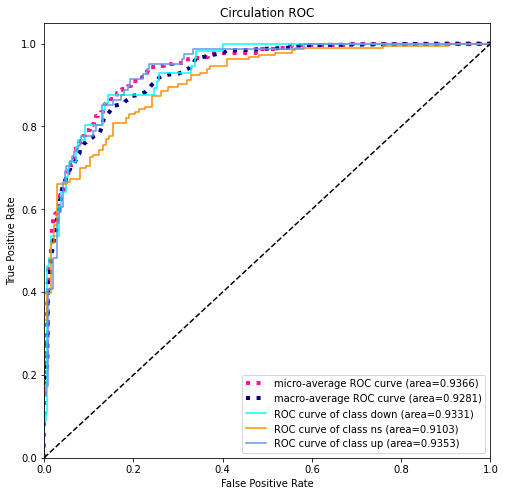

In [ ]:
test_roc()

In [ ]:
test_roc()

0.85625
score_array shape (320, 3)
label_one_hot shape (320, 3)
[0.84551282 0.88985026 0.8680545 ]


0

In [ ]:
def test_metrix():
  
  score_list=[]
  label_list=[]

  
  for idx, data in enumerate(test_dataloader):

    label = data.label
    data = data.cuda()
    
    digits = model_class(data)
    _, predicted = torch.max(digits.data, 1)
    score_temp=predicted
    score_list.extend(score_temp.detach().cpu().numpy())
    label_list.extend(label)
  correct = 0
  for i in range(len(score_list)):
    if label_list[i] == score_list[i]:
      correct += 1
  print(correct/320)

  # score_array = np.array(score_list)
  score_tensor = torch.tensor(score_list)
  score_tensor = score_tensor.reshape(score_tensor.shape[0], 1)
  score_one_hot = torch.zeros(score_tensor.shape[0], 3)
  score_one_hot.scatter_(dim=1, index=score_tensor, value=1)
  score_one_hot = np.array(score_one_hot)

  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape(label_tensor.shape[0], 1)
  label_one_hot = torch.zeros(label_tensor.shape[0], 3)
  label_one_hot.scatter_(dim=1, index=label_tensor, value=1)
  label_one_hot = np.array(label_one_hot)
  ns_c = 0
  for i in range(len(score_list)):
    score_list
  print('score_array shape', score_one_hot.shape)
  print('label_one_hot shape', label_one_hot.shape)
  # roc_curve, auc, f1_score, precision_recall_curve, average_precision_score, roc_auc_score, recall_score, precision_score
  print('roc_auc_score', roc_auc_score(label_one_hot, score_one_hot, average=None))
  print('recall_score', recall_score(label_one_hot, score_one_hot, average=None))
  print('precision_score', precision_score(label_one_hot, score_one_hot, average=None))
  print('f1_score', f1_score(label_one_hot, score_one_hot, average=None))
  return 0

In [ ]:
test_metrix()

0.80625
score_array shape (320, 3)
label_one_hot shape (320, 3)
roc_auc_score [0.79411401 0.83676359 0.81476599]
recall_score [0.63492063 0.90710383 0.7027027 ]
precision_score [0.76923077 0.83838384 0.74285714]
f1_score [0.69565217 0.87139108 0.72222222]


0

## All

### Regression 未做

In [ ]:
model_class = Classificaion_module().cuda()
dataset = MeshRNADataset(x_disease, x_rna, y_soft, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False)

train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-300, 300])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:
def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0

  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0

  # state = default_evaluator.run([[y_pred, y_true]])
  for idx, data in enumerate(test_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)
    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  losses = 0
  losses_l1 = 0
  r2s = 0
  c = 0
  for idx, data in enumerate(val_dataloader):
    label = data.label
    data = data.cuda()
    digits = model_class(data)

    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.LongTensor).cuda()
    loss = criterion(digits, label)
    L1_loss = criterion_L1(digits, label)

    r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (torch.round(digits) == label).sum()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    losses_l1 += L1_loss.item()
    r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  avg_loss_l1 = losses_l1/c
  avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | L1 Loss:{} | R2:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, avg_loss_l1, avg_r2, acc, corrects, the_batch_size))

  return avg_loss, acc, avg_r2, avg_loss_l1

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []
train_loss_record = []
train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
val_r2_record = []
val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
test_r2_record = []
test_loss_l1_record = []

# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(200)):
  repres_list = []
  label_list = []

  for idx, data in (enumerate(dataloader)):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.float32).cuda()
    L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)
    

    # print('torch.round(output): ', torch.round(output))
    
    
    optimizer.zero_grad()
    # if epoch < 10:
    #   loss.backward()
    # else:
    #   L1_loss.backward()
    loss.backward()
    optimizer.step()
    steps += 1
  
  train_loss_record.append(loss.item())
  train_loss_l1_record.append(L1_loss.item())

  val_loss, val_acc, val_r2, val_l1 = val_acc_output(epoch)
  # step_log_interval.append(steps)
  # train_acc_record.append(train_acc)
  val_loss_record.append(val_loss)
  val_r2_record.append(val_r2)
  val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc, test_r2, test_l1 = test_acc_output(epoch)
  # test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  test_r2_record.append(test_r2)
  test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:0.3296254351735115 | L1 Loss:0.4196109399199486 | R2:0.004306853342364324 | ACC: 65.4000%(327/500)
Testing Epoch[0] Loss:0.3399969957768917 | L1 Loss:0.4142574042081833 | R2:-0.005120984381598881 | ACC: 63.3333%(190/300)
Training Epoch[1] Loss:0.3143345592543483 | L1 Loss:0.4138961136341095 | R2:0.0516866560065313 | ACC: 65.0000%(325/500)
Testing Epoch[1] Loss:0.3359823912382126 | L1 Loss:0.415238182246685 | R2:0.028397673702505177 | ACC: 63.0000%(189/300)
Training Epoch[2] Loss:0.2969454349949956 | L1 Loss:0.40616719983518124 | R2:0.10757993295167004 | ACC: 65.0000%(325/500)
Testing Epoch[2] Loss:0.33121492378413675 | L1 Loss:0.41696353554725646 | R2:0.041810402047088656 | ACC: 63.3333%(190/300)
Training Epoch[3] Loss:0.28797789569944143 | L1 Loss:0.39978105388581753 | R2:0.1313539077847189 | ACC: 65.4000%(327/500)
Testing Epoch[3] Loss:0.31714696139097215 | L1 Loss:0.40736897587776183 | R2:0.08653116915736966 | ACC: 63.6667%(191/300)
Training Epoch[4] Loss:0.29

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []
# train_loss_record = []
# train_loss_l1_record = []

# val_acc_record = []
# val_loss_record = []
# val_r2_record = []
# val_loss_l1_record = []

# test_acc_record = []
# test_loss_record = []
# test_r2_record = []
# test_loss_l1_record = []

# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(100)):
  repres_list = []
  label_list = []

  for idx, data in (enumerate(dataloader)):
    label = data.label
    data = data.cuda()
    digits = model_class(data)
    
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    digits = digits.to(torch.float32).squeeze()
    label = label.type(torch.float32).cuda()
    L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)
    

    # print('torch.round(output): ', torch.round(output))
    
    
    optimizer.zero_grad()
    # if epoch < 10:
    #   loss.backward()
    # else:
    #   L1_loss.backward()
    loss.backward()
    optimizer.step()
    steps += 1
  
  train_loss_record.append(loss.item())
  train_loss_l1_record.append(L1_loss.item())

  val_loss, val_acc, val_r2, val_l1 = val_acc_output(epoch)
  # step_log_interval.append(steps)
  # train_acc_record.append(train_acc)
  val_loss_record.append(val_loss)
  val_r2_record.append(val_r2)
  val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc, test_r2, test_l1 = test_acc_output(epoch)
  # test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  test_r2_record.append(test_r2)
  test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:0.1792503520846367 | L1 Loss:0.318916454911232 | R2:0.42235851608198155 | ACC: 79.6000%(398/500)
Testing Epoch[0] Loss:0.21110317707061768 | L1 Loss:0.3559573829174042 | R2:0.18391239896399875 | ACC: 75.6667%(227/300)
Training Epoch[1] Loss:0.1840020762756467 | L1 Loss:0.32465980388224125 | R2:0.41161924329369515 | ACC: 81.2000%(406/500)
Testing Epoch[1] Loss:0.2065364971756935 | L1 Loss:0.35401942431926725 | R2:0.15988851982220903 | ACC: 76.6667%(230/300)
Training Epoch[2] Loss:0.17866325238719583 | L1 Loss:0.32482163794338703 | R2:0.43223496792760685 | ACC: 80.0000%(400/500)
Testing Epoch[2] Loss:0.2095300853252411 | L1 Loss:0.359379968047142 | R2:0.2299105260451027 | ACC: 74.0000%(222/300)
Training Epoch[3] Loss:0.17630019085481763 | L1 Loss:0.31945849768817425 | R2:0.43553953278292723 | ACC: 78.8000%(394/500)
Testing Epoch[3] Loss:0.20743122547864914 | L1 Loss:0.35229367911815646 | R2:0.11278857833492931 | ACC: 75.3333%(226/300)
Training Epoch[4] Loss:0.18008

In [ ]:
print('-----GRU+ GCN 300 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record))

-----GRU+ GCN 300 epochs-----
max test_r2_record  0.29365482372071067
min test_loss_l1_record  0.3385679930448532
min test_loss_record  0.1900847226381302


In [ ]:
print('-----GRU+ GCN 200 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:200]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:200]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:200]))


-----GRU+ GCN 200 epochs-----
max test_r2_record  0.25662598601705594
min test_loss_l1_record  0.3466374784708023
min test_loss_record  0.19679106324911116


In [ ]:
print('-----GRU+ GCN 100 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:100]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:100]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:100]))

-----GRU+ GCN 100 epochs-----
max test_r2_record  0.15542278667731962
min test_loss_l1_record  0.36857505440711974
min test_loss_record  0.2203592985868454


In [ ]:
print('-----GRU+ GCN 50 epochs-----')
# print('max val_r2_record ', max(val_r2_record))
print('max test_r2_record ', max(test_r2_record[:50]))

# print('min val_loss_l1_record ', min(val_loss_l1_record))
print('min test_loss_l1_record ', min(test_loss_l1_record[:50]))

# print('min val_loss_record ', min(val_loss_record))
print('min test_loss_record ', min(test_loss_record[:50]))

-----GRU+ GCN 50 epochs-----
max test_r2_record  0.15542278667731962
min test_loss_l1_record  0.38664981424808503
min test_loss_record  0.2512748628854752


### Classification

In [ ]:
model_class = Classificaion_module().cuda()
# dataset = MeshRNADataset(x_disease, x_rna, y_hard, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=True)
dataset = MeshRNADataset(x_disease, x_rna, y_hard, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False)
train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-640, 640])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

    

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001) # , weight_decay=0.0025
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
# criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:

def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  zeros = 0
  ones = 0
  m_ones = 0
  losses = 0
  # losses_l1 = 0
  # r2s = 0
  c = 0
  
  for idx, data in enumerate(test_dataloader):

    label = data.label
    data = data.cuda()
    # disease = disease.cuda()
    
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long).squeeze()
    _, predicted = torch.max(digits.data, 1)
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)
    
    loss = criterion(digits, label)
    # # loss_l1 = criterion_L1(digits, label)
    # # r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (predicted == label).sum().item()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    # # losses_l1 += loss_l1.item()
    # # r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  # print('label ', label)
  # print('predicted ', predicted)
  # # avg_loss_l1 = losses_l1/c
  # # avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, acc, corrects, the_batch_size))
  # loss = loss.item()
  return avg_loss, acc
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  zeros = 0
  ones = 0
  m_ones = 0
  losses = 0
  # losses_l1 = 0
  # r2s = 0
  c = 0
  
  for idx, data in enumerate(val_dataloader):

    label = data.label
    data = data.cuda()
    # disease = disease.cuda()
    
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long).squeeze()
    _, predicted = torch.max(digits.data, 1)
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)
    loss = criterion(digits, label)
    # # loss_l1 = criterion_L1(digits, label)
    # # r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (predicted == label).sum().item()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    # # losses_l1 += loss_l1.item()
    # # r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  # print('label ', label)
  # print('predicted ', predicted)
  # # avg_loss_l1 = losses_l1/c
  # # avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, acc, corrects, the_batch_size))
  # loss = loss.item()
  return avg_loss, acc
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []

train_loss_record = []
# train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
# val_r2_record = []
# val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
# test_r2_record = []
# test_loss_l1_record = []
# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(300)):
  repres_list = []
  label_list = []

  for idx, data in enumerate(dataloader):
    label = data.label
    data = data.cuda()
    
    
    optimizer.zero_grad()

    digits = model_class(data)
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long)
    # print(type(label))
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)

    # L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)

    # print('torch.round(output): ', torch.round(output))
    
    
    
    loss.backward()
    optimizer.step()
    steps += 1
  train_loss_record.append(loss.item())

  val_loss, val_acc = val_acc_output(epoch)
  # step_log_interval.append(steps)
  val_acc_record.append(val_acc)
  val_loss_record.append(val_loss)
  # val_r2_record.append(val_r2)
  # val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc = test_acc_output(epoch)
  test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  # test_r2_record.append(test_r2)
  # test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:1.0235863961279392 | ACC: 47.8000%(239/500)
Testing Epoch[0] Loss:1.0666760087013245 | ACC: 43.7500%(280/640)
Training Epoch[1] Loss:1.0037893243134022 | ACC: 49.8000%(249/500)
Testing Epoch[1] Loss:1.0544891893863677 | ACC: 45.4688%(291/640)
Training Epoch[2] Loss:0.9794542640447617 | ACC: 52.6000%(263/500)
Testing Epoch[2] Loss:1.0361753404140472 | ACC: 47.1875%(302/640)
Training Epoch[3] Loss:0.9777071997523308 | ACC: 51.8000%(259/500)
Testing Epoch[3] Loss:1.0372651785612106 | ACC: 45.6250%(292/640)
Training Epoch[4] Loss:0.9553368203341961 | ACC: 53.4000%(267/500)
Testing Epoch[4] Loss:1.0296450227499008 | ACC: 47.3438%(303/640)
Training Epoch[5] Loss:0.9417544230818748 | ACC: 54.2000%(271/500)
Testing Epoch[5] Loss:1.0286341041326523 | ACC: 45.9375%(294/640)
Training Epoch[6] Loss:0.9305671751499176 | ACC: 54.6000%(273/500)
Testing Epoch[6] Loss:1.017645600438118 | ACC: 47.1875%(302/640)
Training Epoch[7] Loss:0.9148711375892162 | ACC: 55.8000%(279/500)
Tes

In [ ]:
# 300 epoch second+mature mirna
print('max val_acc_record ', max(val_acc_record))
print('min val_loss_record ', min(val_loss_record))

print('min test_loss_record ', min(test_loss_record))
print('max test_acc_record ', max(test_acc_record))
# max val_acc_record  84.6
# min val_loss_record  0.5722110476344824
# min test_loss_record  0.7427837997674942
# max test_acc_record  75.0

max val_acc_record  73.6
min val_loss_record  0.8190148286521435
min test_loss_record  0.9527886122465133
max test_acc_record  65.0


In [ ]:
torch.save(model_class, '/content/drive/MyDrive/miRNA/last_data/classification_result/all_gcn_gru_300.pt')
torch.save(model_class.state_dict(), '/content/drive/MyDrive/miRNA/last_data/classification_result/all_gcn_gru_300_state.pt')

In [ ]:
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/val_acc_list_all_gcn_gru_300.npy', val_acc_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/val_loss_list_all_gcn_gru_300.npy', val_loss_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/test_loss_list_all_gcn_gru_300.npy', test_loss_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/test_acc_list_all_gcn_gru_300.npy', test_acc_record, allow_pickle=True)


In [ ]:
test_dataloader

In [ ]:
model_class = Classificaion_module().cuda()
model_class.load_state_dict(torch.load('/content/drive/MyDrive/miRNA/last_data/classification_result/all_gcn_gru_300_state.pt'))

<All keys matched successfully>

In [ ]:

def test_roc():
  
  score_list=[]
  score_one_list=[]
  label_list=[]

  
  for idx, data in enumerate(test_dataloader):

    label = data.label
    data = data.cuda()
    
    digits = model_class(data)
    _, predicted = torch.max(digits.data, 1)
    score_temp=digits
    score_list.extend(score_temp.detach().cpu().numpy())
    score_temp=predicted
    score_one_list.extend(score_temp.detach().cpu().numpy())
    label_list.extend(label)
  # correct = 0
  # for i in range(len(score_list)):
  #   if label_list[i] == score_list[i]:
  #     correct += 1
  # print(correct/320)

  score_array = np.array(score_list)
  score_tensor = torch.tensor(score_one_list)
  score_tensor = score_tensor.reshape(score_tensor.shape[0], 1)
  score_one_hot = torch.zeros(score_tensor.shape[0], 3)
  score_one_hot.scatter_(dim=1, index=score_tensor, value=1)
  score_one_hot = np.array(score_one_hot)

  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape(label_tensor.shape[0], 1)
  label_one_hot = torch.zeros(label_tensor.shape[0], 3)
  label_one_hot.scatter_(dim=1, index=label_tensor, value=1)
  label_one_hot = np.array(label_one_hot)
  ns_c = 0
  # for i in range(len(score_list)):
  #   score_list
  print('score_array shape', score_array.shape)
  print('label_one_hot shape', label_one_hot.shape)
  # roc_curve, auc, f1_score, precision_recall_curve, average_precision_score, roc_auc_score, recall_score, precision_score
  print('roc_auc_score', roc_auc_score(label_one_hot, score_array, average=None))
  print('recall_score', recall_score(label_one_hot, score_one_hot, average=None))
  print('precision_score', precision_score(label_one_hot, score_one_hot, average=None))
  print('f1_score', f1_score(label_one_hot, score_one_hot, average=None))
  # return 0

  fpr_dict = dict()
  tpr_dict = dict()
  roc_auc_dict = dict()
  print(score_array.shape)
  for i in range(3):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(label_one_hot[:, i], score_array[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
  
  fpr_dict['micro'], tpr_dict['micro'], _ = roc_curve(label_one_hot.ravel(), score_array.ravel())
  roc_auc_dict['micro'] = auc(fpr_dict['micro'], tpr_dict['micro'])

  all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(3)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
    mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])

  mean_tpr /= 3
  fpr_dict['macro'] = all_fpr
  tpr_dict['macro'] = mean_tpr
  roc_auc_dict['macro'] = auc(fpr_dict['macro'], tpr_dict['macro'])

  plt.figure(figsize=(8, 8))
  lw = 1.5
  plt.plot(fpr_dict['micro'], tpr_dict['micro'], label='micro-average ROC curve (area={0:0.4f})'.format(roc_auc_dict['micro']), color='deeppink', linestyle=':', linewidth=4)
  plt.plot(fpr_dict['macro'], tpr_dict['macro'], label='macro-average ROC curve (area={0:0.4f})'.format(roc_auc_dict['macro']), color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  labels = cycle(['down', 'ns', 'up'])
  # print(fpr_dict[i])
  print(roc_auc_dict[i])
  for i, color, label in zip(range(3), colors, labels):
    plt.plot(fpr_dict[i], tpr_dict[i], lw=lw, color=color, label='ROC curve of class {0} (area={1:0.4f})'.format(label, roc_auc_dict[i]))

  plt.plot([0,1], [0,1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('All ROC')
  plt.legend(loc='lower right')
  plt.savefig('ALL_GRU_GCN_classification_ROC_curve.jpg')
  plt.show()


score_array shape (320, 3)
label_one_hot shape (320, 3)
roc_auc_score [0.80708874 0.8137689  0.83341082]
recall_score [0.625      0.56830601 0.72839506]
precision_score [0.40697674 0.85950413 0.52212389]
f1_score [0.49295775 0.68421053 0.60824742]
(320, 3)
0.833410816674415


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


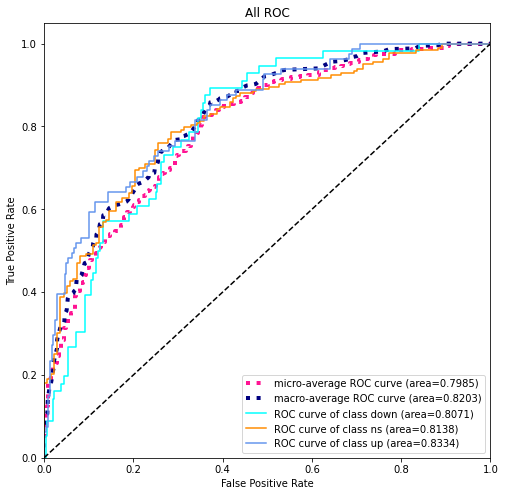

In [ ]:
test_roc()


In [ ]:
test_roc()


0.6328125
score_array shape (640, 3)
label_one_hot shape (640, 3)
[0.71672591 0.72202107 0.72918804]


0

In [ ]:
test_roc()

0.6328125
score_array shape (640, 3)
label_one_hot shape (640, 3)
[0.71672591 0.72202107 0.72918804]


0

In [ ]:
def test_metrix():
  
  score_list=[]
  label_list=[]

  
  for idx, data in enumerate(test_dataloader):

    label = data.label
    data = data.cuda()
    
    digits = model_class(data)
    _, predicted = torch.max(digits.data, 1)
    score_temp=predicted
    score_list.extend(score_temp.detach().cpu().numpy())
    label_list.extend(label)
  correct = 0
  for i in range(len(score_list)):
    if label_list[i] == score_list[i]:
      correct += 1
  print(correct/640)

  # score_array = np.array(score_list)
  score_tensor = torch.tensor(score_list)
  score_tensor = score_tensor.reshape(score_tensor.shape[0], 1)
  score_one_hot = torch.zeros(score_tensor.shape[0], 3)
  score_one_hot.scatter_(dim=1, index=score_tensor, value=1)
  score_one_hot = np.array(score_one_hot)

  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape(label_tensor.shape[0], 1)
  label_one_hot = torch.zeros(label_tensor.shape[0], 3)
  label_one_hot.scatter_(dim=1, index=label_tensor, value=1)
  label_one_hot = np.array(label_one_hot)
  ns_c = 0
  for i in range(len(score_list)):
    score_list
  print('score_array shape', score_one_hot.shape)
  print('label_one_hot shape', label_one_hot.shape)
  # roc_curve, auc, f1_score, precision_recall_curve, average_precision_score, roc_auc_score, recall_score, precision_score
  print('roc_auc_score', roc_auc_score(label_one_hot, score_one_hot, average=None))
  print('recall_score', recall_score(label_one_hot, score_one_hot, average=None))
  print('precision_score', precision_score(label_one_hot, score_one_hot, average=None))
  print('f1_score', f1_score(label_one_hot, score_one_hot, average=None))
  return 0

In [ ]:
test_metrix()

0.6203125
score_array shape (640, 3)
label_one_hot shape (640, 3)
roc_auc_score [0.75847956 0.72840219 0.71149633]
recall_score [0.72093023 0.59580052 0.62427746]
precision_score [0.35428571 0.86311787 0.53465347]
f1_score [0.47509579 0.70496894 0.576     ]


0

## Tissue

### Classification

In [ ]:
model_class = Classificaion_module().cuda()
# dataset = MeshRNADataset(x_disease, x_rna, y_hard, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=True)
dataset = MeshRNADataset(x_disease, x_rna, y_hard, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False)
train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-640, 640])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

    

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001) # , weight_decay=0.0025
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
# criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:

def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  zeros = 0
  ones = 0
  m_ones = 0
  losses = 0
  # losses_l1 = 0
  # r2s = 0
  c = 0
  
  for idx, data in enumerate(test_dataloader):

    label = data.label
    data = data.cuda()
    # disease = disease.cuda()
    
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long).squeeze()
    _, predicted = torch.max(digits.data, 1)
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)
    
    loss = criterion(digits, label)
    # # loss_l1 = criterion_L1(digits, label)
    # # r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (predicted == label).sum().item()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    # # losses_l1 += loss_l1.item()
    # # r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  # print('label ', label)
  # print('predicted ', predicted)
  # # avg_loss_l1 = losses_l1/c
  # # avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, acc, corrects, the_batch_size))
  # loss = loss.item()
  return avg_loss, acc
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  zeros = 0
  ones = 0
  m_ones = 0
  losses = 0
  # losses_l1 = 0
  # r2s = 0
  c = 0
  
  for idx, data in enumerate(val_dataloader):

    label = data.label
    data = data.cuda()
    # disease = disease.cuda()
    
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long).squeeze()
    _, predicted = torch.max(digits.data, 1)
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)
    loss = criterion(digits, label)
    # # loss_l1 = criterion_L1(digits, label)
    # # r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (predicted == label).sum().item()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    # # losses_l1 += loss_l1.item()
    # # r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  # print('label ', label)
  # print('predicted ', predicted)
  # # avg_loss_l1 = losses_l1/c
  # # avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, acc, corrects, the_batch_size))
  # loss = loss.item()
  return avg_loss, acc
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []

train_loss_record = []
# train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
# val_r2_record = []
# val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
# test_r2_record = []
# test_loss_l1_record = []
# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(300)):
  repres_list = []
  label_list = []

  for idx, data in enumerate(dataloader):
    label = data.label
    data = data.cuda()
    
    
    optimizer.zero_grad()

    digits = model_class(data)
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long)
    # print(type(label))
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)

    # L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)

    # print('torch.round(output): ', torch.round(output))
    
    
    
    loss.backward()
    optimizer.step()
    steps += 1
  train_loss_record.append(loss.item())

  val_loss, val_acc = val_acc_output(epoch)
  # step_log_interval.append(steps)
  val_acc_record.append(val_acc)
  val_loss_record.append(val_loss)
  # val_r2_record.append(val_r2)
  # val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc = test_acc_output(epoch)
  test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  # test_r2_record.append(test_r2)
  # test_loss_l1_record.append(test_l1)
  # break
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


Training Epoch[0] Loss:1.0336371883749962 | ACC: 45.4000%(227/500)
Testing Epoch[0] Loss:1.0182917982339859 | ACC: 47.9688%(307/640)
Training Epoch[1] Loss:0.9899523630738258 | ACC: 51.0000%(255/500)
Testing Epoch[1] Loss:1.0081612586975097 | ACC: 46.8750%(300/640)
Training Epoch[2] Loss:0.9416170977056026 | ACC: 53.4000%(267/500)
Testing Epoch[2] Loss:0.9968519151210785 | ACC: 49.3750%(316/640)
Training Epoch[3] Loss:0.9301662184298038 | ACC: 55.0000%(275/500)
Testing Epoch[3] Loss:0.9730575382709503 | ACC: 51.7188%(331/640)
Training Epoch[4] Loss:0.8958520404994488 | ACC: 57.6000%(288/500)
Testing Epoch[4] Loss:0.9804816305637359 | ACC: 50.6250%(324/640)
Training Epoch[5] Loss:0.8898449540138245 | ACC: 58.6000%(293/500)
Testing Epoch[5] Loss:0.9715069234371185 | ACC: 52.1875%(334/640)
Training Epoch[6] Loss:0.8714295104146004 | ACC: 61.6000%(308/500)
Testing Epoch[6] Loss:0.9776925861835479 | ACC: 51.4062%(329/640)
Training Epoch[7] Loss:0.8604600131511688 | ACC: 62.0000%(310/500)
Te

In [ ]:
# 300 epoch second+mature mirna
print('max val_acc_record ', max(val_acc_record))
print('min val_loss_record ', min(val_loss_record))

print('min test_loss_record ', min(test_loss_record))
print('max test_acc_record ', max(test_acc_record))
# Tissue Classification
# max val_acc_record  81.4
# min val_loss_record  0.6155570782721043
# min test_loss_record  0.9715069234371185
# max test_acc_record  68.4375

max val_acc_record  81.4
min val_loss_record  0.6155570782721043
min test_loss_record  0.9715069234371185
max test_acc_record  68.4375


In [ ]:
torch.save(model_class, '/content/drive/MyDrive/miRNA/last_data/classification_result/tis_gcn_gru_300.pt')
torch.save(model_class.state_dict(), '/content/drive/MyDrive/miRNA/last_data/classification_result/tis_gcn_gru_300_state.pt')

In [ ]:
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/val_acc_list_tis_gcn_gru_300.npy', val_acc_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/val_loss_list_tis_gcn_gru_300.npy', val_loss_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/test_loss_list_tis_gcn_gru_300.npy', test_loss_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/test_acc_list_tis_gcn_gru_300.npy', test_acc_record, allow_pickle=True)


In [ ]:
test_dataloader

In [ ]:
model_class = Classificaion_module().cuda()
model_class.load_state_dict(torch.load('/content/drive/MyDrive/miRNA/last_data/classification_result/tis_gcn_gru_300_state.pt'))

<All keys matched successfully>

In [ ]:

def test_roc():
  
  score_list=[]
  score_one_list=[]
  label_list=[]

  
  for idx, data in enumerate(test_dataloader):

    label = data.label
    data = data.cuda()
    
    digits = model_class(data)
    _, predicted = torch.max(digits.data, 1)
    score_temp=digits
    score_list.extend(score_temp.detach().cpu().numpy())
    score_temp=predicted
    score_one_list.extend(score_temp.detach().cpu().numpy())
    label_list.extend(label)
  # correct = 0
  # for i in range(len(score_list)):
  #   if label_list[i] == score_list[i]:
  #     correct += 1
  # print(correct/320)

  score_array = np.array(score_list)
  score_tensor = torch.tensor(score_one_list)
  score_tensor = score_tensor.reshape(score_tensor.shape[0], 1)
  score_one_hot = torch.zeros(score_tensor.shape[0], 3)
  score_one_hot.scatter_(dim=1, index=score_tensor, value=1)
  score_one_hot = np.array(score_one_hot)

  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape(label_tensor.shape[0], 1)
  label_one_hot = torch.zeros(label_tensor.shape[0], 3)
  label_one_hot.scatter_(dim=1, index=label_tensor, value=1)
  label_one_hot = np.array(label_one_hot)
  ns_c = 0
  # for i in range(len(score_list)):
  #   score_list
  # print('score_array shape', score_array.shape)
  # print('label_one_hot shape', label_one_hot.shape)
  # roc_curve, auc, f1_score, precision_recall_curve, average_precision_score, roc_auc_score, recall_score, precision_score
  print('roc_auc_score', roc_auc_score(label_one_hot, score_array, average=None))
  print('recall_score', recall_score(label_one_hot, score_one_hot, average=None))
  print('precision_score', precision_score(label_one_hot, score_one_hot, average=None))
  print('f1_score', f1_score(label_one_hot, score_one_hot, average=None))
  # return 0

  fpr_dict = dict()
  tpr_dict = dict()
  roc_auc_dict = dict()
  # print(score_array.shape)
  for i in range(3):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(label_one_hot[:, i], score_array[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
  
  fpr_dict['micro'], tpr_dict['micro'], _ = roc_curve(label_one_hot.ravel(), score_array.ravel())
  roc_auc_dict['micro'] = auc(fpr_dict['micro'], tpr_dict['micro'])

  all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(3)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
    mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])

  mean_tpr /= 3
  fpr_dict['macro'] = all_fpr
  tpr_dict['macro'] = mean_tpr
  roc_auc_dict['macro'] = auc(fpr_dict['macro'], tpr_dict['macro'])

  plt.figure(figsize=(8, 8))
  lw = 1.5
  plt.plot(fpr_dict['micro'], tpr_dict['micro'], label='micro-average ROC curve (area={0:0.4f})'.format(roc_auc_dict['micro']), color='deeppink', linestyle=':', linewidth=4)
  plt.plot(fpr_dict['macro'], tpr_dict['macro'], label='macro-average ROC curve (area={0:0.4f})'.format(roc_auc_dict['macro']), color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  labels = cycle(['down', 'ns', 'up'])
  # print(fpr_dict[i])
  print(roc_auc_dict[i])
  for i, color, label in zip(range(3), colors, labels):
    plt.plot(fpr_dict[i], tpr_dict[i], lw=lw, color=color, label='ROC curve of class {0} (area={1:0.4f})'.format(label, roc_auc_dict[i]))

  plt.plot([0,1], [0,1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Tissue ROC')
  plt.legend(loc='lower right')
  plt.savefig('Tissue_GRU_GCN_classification_ROC_curve.jpg')
  plt.show()


roc_auc_score [0.8144042  0.83414711 0.80213437]
recall_score [0.64550265 0.67821782 0.67871486]
precision_score [0.62886598 0.66504854 0.70416667]
f1_score [0.63707572 0.67156863 0.69120654]
0.8021343686767529


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


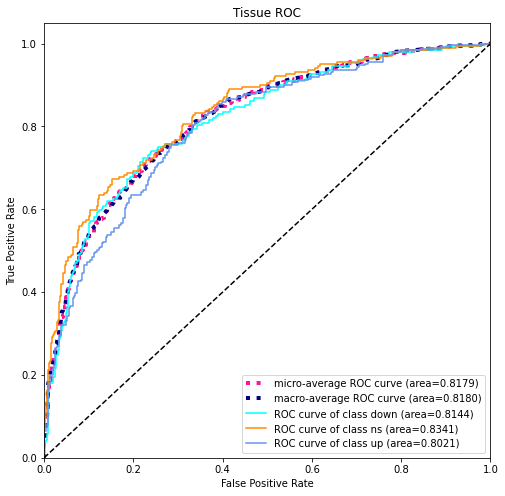

In [ ]:
test_roc()
# Tissue

## Gen

### Classification

In [ ]:
model_class = Classificaion_module().cuda()
# dataset = MeshRNADataset(x_disease, x_rna, y_hard, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=True)
dataset = MeshRNADataset(x_disease, x_rna, y_hard, edge_d, edge_attr_d, node_d, hair_x, is_conv1d=False)
train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-640, 640])
val_dataset, _ = torch.utils.data.random_split(train_set, [500,len(train_set)-500])
dataloader = PYG_DataLoader(train_set, batch_size=32)
test_dataloader = PYG_DataLoader(test_set, batch_size=32)
val_dataloader = PYG_DataLoader(val_dataset, batch_size=32)

    

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
optimizer = torch.optim.AdamW(params=model_class.parameters(), lr=0.001) # , weight_decay=0.0025
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
# criterion_L1 = nn.L1Loss()

In [ ]:
model_class.train()
model_class

Classificaion_module(
  (gru_module): GRU_module(
    (gru): GRU(30, 64, num_layers=2, dropout=0.5, bidirectional=True)
    (FC): Linear(in_features=128, out_features=64, bias=True)
  )
  (gcn): GCN(
    (initial_conv): GCNConv(300, 256)
    (bn_1): BatchNorm(256)
    (conv1): GCNConv(256, 128)
    (bn_2): BatchNorm(128)
    (conv2): GCNConv(128, 128)
    (bn_3): BatchNorm(128)
    (conv3): GCNConv(128, 64)
    (bn_4): BatchNorm(64)
    (out): Linear(in_features=128, out_features=64, bias=True)
  )
  (mlp_sec): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, af

In [ ]:

def test_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  zeros = 0
  ones = 0
  m_ones = 0
  losses = 0
  # losses_l1 = 0
  # r2s = 0
  c = 0
  
  for idx, data in enumerate(test_dataloader):

    label = data.label
    data = data.cuda()
    # disease = disease.cuda()
    
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long).squeeze()
    _, predicted = torch.max(digits.data, 1)
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)
    
    loss = criterion(digits, label)
    # # loss_l1 = criterion_L1(digits, label)
    # # r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (predicted == label).sum().item()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    # # losses_l1 += loss_l1.item()
    # # r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  # print('label ', label)
  # print('predicted ', predicted)
  # # avg_loss_l1 = losses_l1/c
  # # avg_r2 = r2s/c
  print('\rTesting Epoch[{}] Loss:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, acc, corrects, the_batch_size))
  # loss = loss.item()
  return avg_loss, acc
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
def val_acc_output(epoch):
  corrects = 0
  the_batch_size = 0
  zeros = 0
  ones = 0
  m_ones = 0
  losses = 0
  # losses_l1 = 0
  # r2s = 0
  c = 0
  
  for idx, data in enumerate(val_dataloader):

    label = data.label
    data = data.cuda()
    # disease = disease.cuda()
    
    digits = model_class(data)
    # digits = F.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long).squeeze()
    _, predicted = torch.max(digits.data, 1)
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)
    loss = criterion(digits, label)
    # # loss_l1 = criterion_L1(digits, label)
    # # r2 = r2_score(label.cpu().detach().numpy(), digits.cpu().detach().numpy())
    corrects += (predicted == label).sum().item()
    the_batch_size += label.shape[0]
    c += 1
    losses += loss.item()
    # # losses_l1 += loss_l1.item()
    # # r2s += r2
  acc = 100.0 * corrects / the_batch_size
  avg_loss = losses/c
  # print('label ', label)
  # print('predicted ', predicted)
  # # avg_loss_l1 = losses_l1/c
  # # avg_r2 = r2s/c
  print('\rTraining Epoch[{}] Loss:{} | ACC: {:.4f}%({}/{})'.format(epoch, avg_loss, acc, corrects, the_batch_size))
  # loss = loss.item()
  return avg_loss, acc
  # corrects = (torch.max(logits, 1)[1] == label).sum()

In [ ]:
steps = 0
best_acc = 0
best_performance = 0
step_log_interval = []

train_loss_record = []
# train_loss_l1_record = []

val_acc_record = []
val_loss_record = []
# val_r2_record = []
# val_loss_l1_record = []

test_acc_record = []
test_loss_record = []
# test_r2_record = []
# test_loss_l1_record = []
# for epoch in tqdm(range(1, config.epoch + 1)):
for epoch in (range(300)):
  repres_list = []
  label_list = []

  for idx, data in enumerate(dataloader):
    label = data.label
    data = data.cuda()
    
    
    optimizer.zero_grad()

    digits = model_class(data)
    # digits = torch.tanh(digits)
    # print('output: ', output.shape)
    # digits = digits.to(torch.long)
    # print(type(label))
    label = torch.Tensor(np.array(label)).cuda()
    label = label.to(torch.long)

    # L1_loss = criterion_L1(digits, label)
    loss = criterion(digits, label)

    # print('torch.round(output): ', torch.round(output))
    
    
    
    loss.backward()
    optimizer.step()
    steps += 1
  train_loss_record.append(loss.item())

  val_loss, val_acc = val_acc_output(epoch)
  # step_log_interval.append(steps)
  val_acc_record.append(val_acc)
  val_loss_record.append(val_loss)
  # val_r2_record.append(val_r2)
  # val_loss_l1_record.append(val_l1)
  # train_loss_record.append(loss)
  test_loss, test_acc = test_acc_output(epoch)
  test_acc_record.append(test_acc)
  test_loss_record.append(test_loss)
  # test_r2_record.append(test_r2)
  # test_loss_l1_record.append(test_l1)
  # break
    

Training Epoch[0] Loss:0.5448716897517443 | ACC: 75.4000%(377/500)
Testing Epoch[0] Loss:0.5978936195373535 | ACC: 70.9375%(454/640)
Training Epoch[1] Loss:0.48672997392714024 | ACC: 77.0000%(385/500)
Testing Epoch[1] Loss:0.563891963660717 | ACC: 72.8125%(466/640)
Training Epoch[2] Loss:0.4613758083432913 | ACC: 78.0000%(390/500)
Testing Epoch[2] Loss:0.5485683917999268 | ACC: 72.3438%(463/640)
Training Epoch[3] Loss:0.41282276250422 | ACC: 82.0000%(410/500)
Testing Epoch[3] Loss:0.5162147551774978 | ACC: 76.2500%(488/640)
Training Epoch[4] Loss:0.38254330679774284 | ACC: 82.4000%(412/500)
Testing Epoch[4] Loss:0.5065957188606263 | ACC: 75.6250%(484/640)
Training Epoch[5] Loss:0.3497834876179695 | ACC: 85.0000%(425/500)
Testing Epoch[5] Loss:0.4982570856809616 | ACC: 77.1875%(494/640)
Training Epoch[6] Loss:0.34126588329672813 | ACC: 85.6000%(428/500)
Testing Epoch[6] Loss:0.4974013239145279 | ACC: 75.7812%(485/640)
Training Epoch[7] Loss:0.31507469713687897 | ACC: 86.6000%(433/500)
T

In [ ]:
# 300 epoch second+mature mirna
print('max val_acc_record ', max(val_acc_record))
print('min val_loss_record ', min(val_loss_record))

print('min test_loss_record ', min(test_loss_record))
print('max test_acc_record ', max(test_acc_record))
# max val_acc_record  84.6
# min val_loss_record  0.5722110476344824
# min test_loss_record  0.7427837997674942
# max test_acc_record  75.0

max val_acc_record  95.8
min val_loss_record  0.16377647849731147
min test_loss_record  0.4974013239145279
max test_acc_record  86.40625


In [ ]:
torch.save(model_class, '/content/drive/MyDrive/miRNA/last_data/classification_result/gen_gcn_gru_300.pt')
torch.save(model_class.state_dict(), '/content/drive/MyDrive/miRNA/last_data/classification_result/gen_gcn_gru_300_state.pt')

In [ ]:
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/val_acc_list_gen_gcn_gru_300.npy', val_acc_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/val_loss_list_gen_gcn_gru_300.npy', val_loss_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/test_loss_list_gen_gcn_gru_300.npy', test_loss_record, allow_pickle=True)
np.save('/content/drive/MyDrive/miRNA/last_data/classification_result/test_acc_list_gen_gcn_gru_300.npy', test_acc_record, allow_pickle=True)


In [ ]:
test_dataloader

In [ ]:
model_class = Classificaion_module().cuda()
model_class.load_state_dict(torch.load('/content/drive/MyDrive/miRNA/last_data/classification_result/gen_gcn_gru_300_state.pt'))

<All keys matched successfully>

In [ ]:

def test_roc():
  
  score_list=[]
  score_one_list=[]
  label_list=[]

  
  for idx, data in enumerate(test_dataloader):

    label = data.label
    data = data.cuda()
    
    digits = model_class(data)
    _, predicted = torch.max(digits.data, 1)
    score_temp=digits
    score_list.extend(score_temp.detach().cpu().numpy())
    score_temp=predicted
    score_one_list.extend(score_temp.detach().cpu().numpy())
    label_list.extend(label)
  # correct = 0
  # for i in range(len(score_list)):
  #   if label_list[i] == score_list[i]:
  #     correct += 1
  # print(correct/320)

  score_array = np.array(score_list)
  score_tensor = torch.tensor(score_one_list)
  score_tensor = score_tensor.reshape(score_tensor.shape[0], 1)
  score_one_hot = torch.zeros(score_tensor.shape[0], 2)
  score_one_hot.scatter_(dim=1, index=score_tensor, value=1)
  score_one_hot = np.array(score_one_hot)

  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape(label_tensor.shape[0], 1)
  label_one_hot = torch.zeros(label_tensor.shape[0], 2)
  label_one_hot.scatter_(dim=1, index=label_tensor, value=1)
  label_one_hot = np.array(label_one_hot)
  ns_c = 0
  # for i in range(len(score_list)):
  #   score_list
  print('score_array shape', score_array.shape)
  print('label_one_hot shape', label_one_hot.shape)
  print(len(np.unique(label_tensor)))
  # roc_curve, auc, f1_score, precision_recall_curve, average_precision_score, roc_auc_score, recall_score, precision_score
  print('roc_auc_score', roc_auc_score(label_one_hot, score_array, average=None))
  print('recall_score', recall_score(label_one_hot, score_one_hot, average=None))
  print('precision_score', precision_score(label_one_hot, score_one_hot, average=None))
  print('f1_score', f1_score(label_one_hot, score_one_hot, average=None))
  # return 0

  fpr_dict = dict()
  tpr_dict = dict()
  roc_auc_dict = dict()
  # print(score_array.shape)
  for i in range(2):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(label_one_hot[:, i], score_array[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
  
  fpr_dict['micro'], tpr_dict['micro'], _ = roc_curve(label_one_hot.ravel(), score_array.ravel())
  roc_auc_dict['micro'] = auc(fpr_dict['micro'], tpr_dict['micro'])

  all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(2)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(2):
    mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])

  mean_tpr /= 2
  fpr_dict['macro'] = all_fpr
  tpr_dict['macro'] = mean_tpr
  roc_auc_dict['macro'] = auc(fpr_dict['macro'], tpr_dict['macro'])

  plt.figure(figsize=(8, 8))
  lw = 1.5
  plt.plot(fpr_dict['micro'], tpr_dict['micro'], label='micro-average ROC curve (area={0:0.4f})'.format(roc_auc_dict['micro']), color='deeppink', linestyle=':', linewidth=4)
  plt.plot(fpr_dict['macro'], tpr_dict['macro'], label='macro-average ROC curve (area={0:0.4f})'.format(roc_auc_dict['macro']), color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange'])
  labels = cycle(['down', 'up'])
  # print(fpr_dict[i])
  print(roc_auc_dict[i])
  for i, color, label in zip(range(2), colors, labels):
    plt.plot(fpr_dict[i], tpr_dict[i], lw=lw, color=color, label='ROC curve of class {0} (area={1:0.4f})'.format(label, roc_auc_dict[i]))

  plt.plot([0,1], [0,1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Genetics ROC')
  plt.legend(loc='lower right')
  plt.savefig('Genetics_GRU_GCN_classification_ROC_curve.jpg')
  plt.show()


score_array shape (640, 2)
label_one_hot shape (640, 2)
2
roc_auc_score [0.89157581 0.89107928]
recall_score [0.89705882 0.7887931 ]
precision_score [0.88192771 0.81333333]
f1_score [0.88942892 0.80087527]
0.8910792765382016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


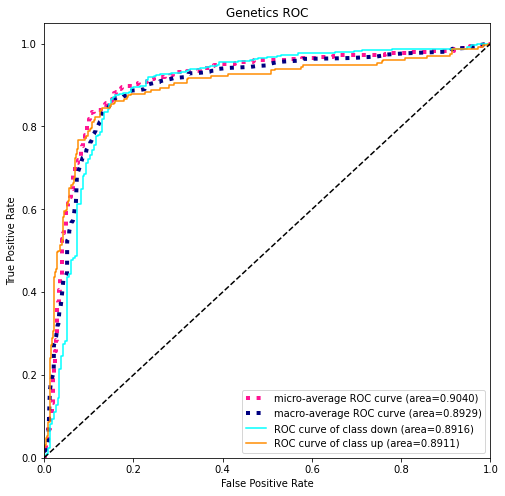

In [ ]:
test_roc()
